## StackOverFlow Developer Survey Analysis [Simplified version]

In [1]:
import pandas as pd
from pathlib import Path
from datetime import datetime
import requests
import zipfile
import shutil
import os

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# filter the warning for now on
#import warnings
#warnings.simplefilter("ignore", DeprecationWarning)

# new way to create an ordered category
from pandas.api.types import CategoricalDtype

## OVERVIEW

As the business world adapts to the massive disrutption of internet and the consumer epxectations driven by unleashed by the first movers and innovators in Tech, DATA SCIENTISTS have become hightly sought after.  This has made it a very attractive career building on the customs and tools pioneered by individuals in Academic Science and Computer Programming disciplines. 

Data Science is a hot field; however, are the people doing "the best job in America" really any different from other developers?  Lets use the annual Stack Overflow Developers Survey to try and find out.


---
## DATASET Description:

The data set is the full, cleaned results of the 2019 Stack Overflow Developer Survey, downloaded from: <https://insights.stackoverflow.com/survey>.   The survey was fielded from January 23 to February 14, 2019. The median time spent on the survey for qualified responses was 23.3 minutes.  Unfortunately, free response submissions and personally identifying information have been removed from the pubicly available data in order to protect the privacy of respondents. 

Respondents were recruited primarily through channels owned by Stack Overflow. The top 5 sources of respondents were onsite messaging, blog posts, email lists, Meta posts, banner ads, and social media posts. Since respondents were recruited in this way, highly engaged users on Stack Overflow were more likely to notice the links for the survey and click to begin it. This community is _highly_ biased compared with the general population.  Heavy on white males from the US.



### Data Files

There two files of interest are a CSV table of results, and a schema table containing the questions.   For theis analysis we'll just need the survey.csv which we will download and save to a local file re-coded by the year in case we want to look at additional years of data in the future.

In [9]:
today = datetime.today()
survey_year = 2019
# in case we want to reuse code for other years
in_file = Path.cwd() / 'data' / 'raw' / f'survey{survey_year}.csv'
# this is where our cleaned up file will put put
summary_file = Path.cwd() / 'data' / 'processed' / \
    'summary_{today:%b-%d-%Y}.pkl'

In [10]:
# download the data if its not in the local directory
if not os.path.exists(in_file):
    # put these here in case we want to look at any other years...
    url = 'https://drive.google.com/uc?export=download&id=1QOmVDpd8hcVYqqUXDXf68UMDWQZP0wQV'
    survey_filename = 'survey_results_public.csv'
    questions_filename = 'survey_results_schema.csv'
    print('Downloading {} survey'.format(survey_year))

    request = requests.get(url)
    with open('survey.zip', 'wb') as file:
        file.write(request.content)

    print('Unzipping {} survey'.format(survey_year))
    with zipfile.ZipFile("survey.zip", "r") as file:
        file.extractall("data/external/")

    print('Moving {} survey'.format(year))
    shutil.copytree('data/external', 'data/raw')
    shutil.copy('data/external/' + survey_filename,
                'data/raw/survey{}.csv'.format(survey_year))
    shutil.copy('data/external/' + questions_filename,
                'data/raw/schema{}.csv'.format(survey_year))

    print('cleaning up')
    os.remove('survey.zip')

---
##  OUTLINE

0. OVERVIEW
    * Context
    * Dataset & files
    * Outline (.\__self__)
1. EXPLORE & FRAME  
    * Describe the data
        * summarry stats & plots  
    * Clean and simplify data
    * Derive new features 
2. RESEARCH QUESTIONS
    * Are Data Scientists a different breed of developer? 
3. SUMMARRY AND NEXT STEPS
    * So what?


---
---

# EXPLORE 

## The StackOverflow Developers Survey.

Lets have a look at what we are working with and how we can start to probe which features to look at.

In [14]:
# beware that the Respondent ids start at 1
df = pd.read_csv(in_file, index_col='Respondent')
# Print column name
df.shape

(88883, 84)

In [15]:
df.columns

Index(['MainBranch', 'Hobbyist', 'OpenSourcer', 'OpenSource', 'Employment',
       'Country', 'Student', 'EdLevel', 'UndergradMajor', 'EduOther',
       'OrgSize', 'DevType', 'YearsCode', 'Age1stCode', 'YearsCodePro',
       'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney', 'MgrWant', 'JobSeek',
       'LastHireDate', 'LastInt', 'FizzBuzz', 'JobFactors', 'ResumeUpdate',
       'CurrencySymbol', 'CurrencyDesc', 'CompTotal', 'CompFreq',
       'ConvertedComp', 'WorkWeekHrs', 'WorkPlan', 'WorkChallenge',
       'WorkRemote', 'WorkLoc', 'ImpSyn', 'CodeRev', 'CodeRevHrs', 'UnitTests',
       'PurchaseHow', 'PurchaseWhat', 'LanguageWorkedWith',
       'LanguageDesireNextYear', 'DatabaseWorkedWith',
       'DatabaseDesireNextYear', 'PlatformWorkedWith',
       'PlatformDesireNextYear', 'WebFrameWorkedWith',
       'WebFrameDesireNextYear', 'MiscTechWorkedWith',
       'MiscTechDesireNextYear', 'DevEnviron', 'OpSys', 'Containers',
       'BlockchainOrg', 'BlockchainIs', 'BetterLife', 'ITperson', 

The dataframe is nice and tidy:  no empty columns, mostly self-explanatory column names, etc. Only the columns resulting from multi-selections will be tricky.  These contain strings with semicolon separated values specifying the selections.

---
As we can see almost  3 of every 4 respondents are Professional developers (from the column `MainBranch` which corresponds to the surveys first question).  The remaining 26% represent Students, Occational coders, Hobbiests, and retired Developers. After filtering down to include only to Professinals we will stil lhave over 65k respondents to analyze.

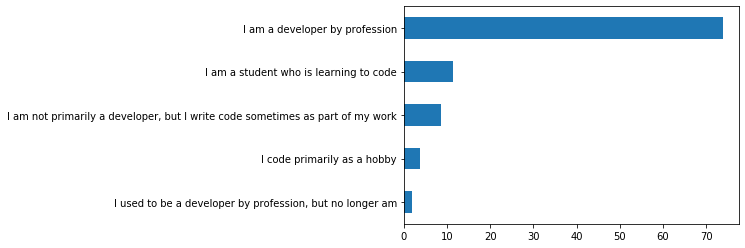

In [16]:
(100.0*df['MainBranch'].value_counts()/df.shape[0]).sort_values().plot('barh')
#df['MainBranch'].value_counts().sort_values().plot('barh')

In [17]:
# filter our respondents to be Professionals
df = df[df['MainBranch'] == 'I am a developer by profession']

In [18]:
print('The dataset contains', df.shape[0], 'rows and', df.shape[1], 'columns.')

The dataset contains 65679 rows and 84 columns.


In [19]:
# convert dtypes to categories for the features we want to analyze...
convert_to_cat = ['MainBranch', 'Gender', 'Trans', 'Sexuality', 'Ethnicity', 'Dependents', 'Student', 'UndergradMajor',
                  'Employment',  'OrgSize',
                  'CareerSat', 'BlockchainOrg', 'OpSys', 'OpenSourcer',
                  'MgrIdiot', 'MgrMoney', 'MgrWant', 'BlockchainIs', 'BetterLife', 'ITperson', 'OffOn', 'ScreenName', 'SocialMedia', 'Extraversion',
                  'SurveyLength', 'SurveyEase', 'Hobbyist']

for col_name in convert_to_cat:
    if(df[col_name].dtype == 'object'):
        df[col_name] = df[col_name].astype('category')
        # df.loc[:,col_name] = df[col_name].cat.codes  # could do this to make everything ready for ML

In [22]:
df['DevType'].head(25)

Respondent
4                                 Developer, full-stack
5     Academic researcher;Developer, desktop or ente...
7                         Designer;Developer, front-end
9     Database administrator;Developer, back-end;Dev...
10    Data or business analyst;Data scientist or mac...
13    Data or business analyst;Database administrato...
14        Developer, desktop or enterprise applications
16                                Developer, full-stack
17    Developer, back-end;Developer, front-end;Devel...
19                                Developer, full-stack
22    Data or business analyst;Designer;Developer, b...
23                                Developer, full-stack
24                                 Developer, front-end
25    Designer;Developer, back-end;Developer, front-...
26    Designer;Developer, back-end;Developer, deskto...
28    Designer;Developer, front-end;Developer, full-...
29                        Developer, front-end;Educator
30         DevOps specialist;Engineer

### Developer types
Beyond keeping professionals only, by dropping students, hobbyists, and other respondents, we want to find Data Scientists (DSs) as well as some other groups for comparing them against.   We'll define somewhat arbitrarily DSs as any respondent as the union of Data scientists, data analysits" machine learning specialists and academic scientists, (but not data engineers).  Non-DSs are everyone else!   We also define Developers (DEVs) as all traditional developer types (i.e. front-end, back-end, full stacke, etc.).  DSs and DEVs are not mutually exclusive so we also fill out the venn diagriam between DS, DEVs and other for occational sanity checks.


In [25]:
# Create data scientist and non-data scientist subsets.
# data scientists are defined as "Data or business analyst",Engineer, Data",
#       "Data scientist or machine learning specialist"
# Database administrator or Scientist

# developer is "Developer, {fullstack, game or graphics, mobile, QA or test}"
# exclude database administrator by having space after data
data_scientist = df['DevType'].str.contains(
    '|'.join(['data ', 'scientist']), case=False, na=False, regex=True).copy()  # data scientists / analists / Data engineers

# data = df['DevType'].str.contains('data', case=False, na=False, regex=True).copy() #data scientists / analists / Data engineers
developer = df['DevType'].str.contains(
    'developer', case=False, na=False, regex=True).copy()  # all types of developers


print('we have {} DataScientists and {} traditional Developers in our professional Developers database'.format(
    data_scientist.sum(), developer.sum()))

we have 8057 DataScientists and 61987 traditional Developers in our professional Developers database


In [26]:
# make some expository columns
df.loc[:, 'isDS'] = data_scientist
df.loc[:, 'isDev'] = developer
df.loc[:, 'notDS'] = ~data_scientist
df.loc[:, 'DSonly'] = data_scientist & ~developer
df.loc[:, 'DSandDev'] = data_scientist & developer
df.loc[:, 'otherDev'] = ~data_scientist & ~ developer
df.loc[:, 'DSorNOT'] = np.nan
df.loc[data_scientist,'DSorNOT'] = 1.0
df.loc[~data_scientist,'DSorNOT'] = 0.0

df[['isDS','notDS','isDev','DSonly','DSandDev','otherDev','DSorNOT']].agg(['mean','sum'])


,isDS,notDS,isDev,DSonly,DSandDev,otherDev,DSorNOT
mean,0.122672,0.877328,0.943787,0.019808,0.102864,0.036404,0.122672
sum,8057.000000,57622.000000,61987.000000,1301.000000,6756.000000,2391.000000,8057.000000


### categorical variables

Most of our columns are derived from choosing among a limited number of choices.  Hence, they are categorical.  We'll want to keep the ordering of naturally heirarchal features, such as education.

In [92]:
# Convert these to ordered categories
# Education
edlevel_cat = CategoricalDtype(['I never completed any formal education',
                                'Primary/elementary school',
                                'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
                                'Some college/university study without earning a degree',
                                'Associate degree',
                                'Bachelor’s degree (BA, BS, B.Eng., etc.)',
                                'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
                                'Professional degree (JD, MD, etc.)',
                                'Other doctoral degree (Ph.D, Ed.D., etc.)'], ordered=True)

df['EdLevel'] = df.EdLevel.astype(edlevel_cat)

# OpenSource . Higher, same lower
opensource_cat = CategoricalDtype(['OSS is, on average, of HIGHER quality than proprietary / closed source software',
                                   'The quality of OSS and closed source software is about the same',
                                   'OSS is, on average, of LOWER quality than proprietary / closed source software', ], ordered=True)
df['OpenSource'] = df.OpenSource.astype(opensource_cat)

# career satisfaction / job satisfaction\
careersat_cat = CategoricalDtype(['Very dissatisfied',
                                  'Slightly dissatisfied',
                                  'Neither satisfied nor dissatisfied',
                                  'Slightly satisfied',
                                  'Very satisfied'], ordered=True)
df['CareerSat'] = df.CareerSat.astype(careersat_cat)

jobsat_cat = CategoricalDtype(['Very dissatisfied',
                               'Slightly dissatisfied',
                               'Neither satisfied nor dissatisfied',
                               'Slightly satisfied',
                               'Very satisfied'], ordered=True)
df['JobSat'] = df.JobSat.astype(jobsat_cat)

# competence
impsyn_cat = CategoricalDtype(['Far below average',
                               'A little below average',
                               'Average',
                               'A little above average',
                               'Far above average'], ordered=True)
df['ImpSyn'] = df.ImpSyn.astype(impsyn_cat)

print('The dataset contains', df.shape[0], 'rows and', df.shape[1], 'columns.')

The dataset contains 65679 rows and 68 columns.


# Research Questions

In order to explore whether the cohort of Data Scientists are different from traditional Developers lets explore their DEMOGRAPHICS, their SKILLS&TOOLS, and some ATTITUDES/CULTURAL probes. 

We will focus on the the DEMOGRAPHIC, ATTITUDANAL, as well as some WORK and CODING relate for further analysis.

The motivation behind this analysis is to explore how data scientists compare with non-data scientist developers ("non-data scientists"). Consequently, we set out to answer the following questions:

1. **Are there demographic differences?**  Hypothesis:  higher educated and more likely from math/science than computer/tech.  Intuition also dictates that DS are younger and less experienced.
2. **Are their attitudes different?** 
3. **Are their skills, tools, and work situations different?**
4. **Can we predict if a developer professional developer is a Data Scientist?**        

We'll enumerate some lists of our columns of interest for reference, and for filtering.  We'll also define a few functions to simplify plotting and processing.

In [27]:
# df.columns
# Drop unnecessary columns
demographic_cols = ['MainBranch', 'Age', 'Gender', 'Trans', 'Sexuality', 'Ethnicity',
                    'Dependents', 'Country', 'Student', 'EdLevel', 'UndergradMajor']  # , 'EduOther']

attitude_cols = ['ImpSyn', 'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney', 'MgrWant', 'JobFactors',
                 'BlockchainIs', 'BetterLife', 'ITperson', 'OffOn',  'SocialMedia', 'Extraversion',
                 'ScreenName', 'OpenSource']

work_cols = ['ConvertedComp',  'WorkWeekHrs' 'Employment', 'OrgSize']  # ,
#'JobSeek', 'LastHireDate', 'LastInt', 'ResumeUpdate',
#'CompTotal', 'CurrencySymbol','CurrencyDesc', 'CompTotal', 'CompFreq',
#'WorkPlan', 'WorkChallenge', 'WorkRemote', 'WorkLoc', 'CodeRev', 'CodeRevHrs', 'UnitTests',
# 'PurchaseHow', 'PurchaseWhat']

# keep all of these
skills_cols = ['YearsCode', 'Age1stCode', 'YearsCodePro', 'OpenSourcer', 'DevType',  'LanguageWorkedWith',
               'LanguageDesireNextYear', 'DevEnviron', 'OpSys', 'Containers', 'BlockchainOrg', 'FizzBuzz',
               'DatabaseWorkedWith', 'DatabaseDesireNextYear', 'PlatformWorkedWith',   'PlatformDesireNextYear',
               'MiscTechWorkedWith', 'MiscTechDesireNextYear', 'WebFrameWorkedWith', 'WebFrameDesireNextYear']

misc_cols = ['Hobbyist', 'SurveyLength', 'SurveyEase']

# drop all of these
stackoverflow_cols = ['SOVisit1st', 'SOVisitFreq', 'SOVisitTo', 'SOFindAnswer', 'SOTimeSaved', 'SOHowMuchTime',
                      'SOAccount', 'SOPartFreq', 'SOJobs', 'EntTeams', 'SOComm', 'WelcomeChange', 'SONewContent']

# added columns
types_cols = ['isDS', 'notDS', 'isDev', 'DSonly', 'DSandDev', 'otherDev']

drop_cols = ['JobSeek', 'LastHireDate', 'LastInt', 'ResumeUpdate',
             'CompTotal', 'CurrencySymbol', 'CurrencyDesc', 'CompTotal', 'CompFreq',
             'WorkPlan', 'WorkChallenge', 'WorkRemote', 'WorkLoc', 'CodeRev', 'CodeRevHrs', 'UnitTests',
             'PurchaseHow', 'PurchaseWhat',
             'EduOther', 'SOVisit1st', 'SOVisitFreq', 'SOVisitTo', 'SOFindAnswer', 'SOTimeSaved', 'SOHowMuchTime',
             'SOAccount', 'SOPartFreq', 'SOJobs', 'EntTeams', 'SOComm', 'WelcomeChange', 'SONewContent']

df = df.drop(drop_cols, axis=1)

#df = df[keep_columns]

In [28]:
def plot_dev_vs_df(df_dev, df_ds, title_text, xlimit, ylabel_text):

    fig = plt.figure(figsize=(15, 12))
    grid_size = (10, 10)  # lets space stuff out...
    SOURCE_TEXT = 'Source: StackOverFlow Dev survey, 2019'

    #title_text = 'language LOVE (use now AND want to use it next year'
    #xlimit = {0,95} #

    xlabel_text = 'Incidence (pct)'

    # Place A Title On The Figure
    fig.text(x=0.995, y=0.02, s=SOURCE_TEXT, verticalalignment='bottom',
             rotation='vertical', color='#524939')
    # Overlay multiple plots onto the same axis, which spans 1 entire column of the figure
    tall_left_ax = plt.subplot2grid(grid_size, (1, 1), colspan=3, rowspan=9)
    tall_right_ax = plt.subplot2grid(grid_size, (1, 6), colspan=3, rowspan=9)
    #ax1 = lang_pct.plot.barh(ax=tall_left_ax,legend=False, title='All Respondents',label='xxx',x='string',y='lang')
    ax1 = df_dev.plot.barh(ax=tall_left_ax,
                           legend=False,
                           title='Developers').set(xlabel=xlabel_text, ylabel=ylabel_text, xlim=xlimit)
    ax2 = df_ds.plot.barh(ax=tall_right_ax,
                          legend=False,
                          title='Data Scientists').set(xlabel=xlabel_text, xlim=xlimit)
    # plt.tight_layout()
    plt.suptitle(title_text, fontsize=22)
    # should also move the ylabels to the right side for the second plot...

In [29]:
def plot_2col(df_dev, df_ds, title_text, xlimit, xlabel_text, ylabel_text, ptype):

    fig = plt.figure(figsize=(15, 12))
    grid_size = (10, 10)  # lets space stuff out...
    SOURCE_TEXT = 'Source: StackOverFlow Dev survey, 2019'

    # Place A Title On The Figure
    fig.text(x=0.995, y=0.02, s=SOURCE_TEXT, verticalalignment='bottom',
             rotation='vertical', color='#524939')
    # Overlay multiple plots onto the same axis, which spans 1 entire column of the figure
    tall_left_ax = plt.subplot2grid(grid_size, (1, 1), colspan=3, rowspan=9)
    tall_right_ax = plt.subplot2grid(grid_size, (1, 6), colspan=3, rowspan=9)

    if ptype == 'barh':
        #ax1 = lang_pct.plot.barh(ax=tall_left_ax,legend=False, title='All Respondents',label='xxx',x='string',y='lang')
        ax1 = df_dev.plot.barh(ax=tall_left_ax,
                               legend=False, title='Developers').set(xlabel=xlabel_text,
                                                                     ylabel=ylabel_text,
                                                                     xlim=xlimit)
        ax2 = df_ds.plot.barh(ax=tall_right_ax,
                              legend=False,
                              title='Data Scientists').set(xlabel=xlabel_text,
                                                           xlim=xlimit)
    elif ptype == 'pie':

        #ax1 = lang_pct.plot.barh(ax=tall_left_ax,legend=False, title='All Respondents',label='xxx',x='string',y='lang')
        ax1 = df_dev.plot.pie(
            ax=tall_left_ax, legend=False, title='Developers')
        ax2 = df_ds.plot.pie(ax=tall_right_ax, legend=False,
                             title='Data Scientists')

    else:
        ax1 = lang_pct.plot.bar(ax=tall_left_ax, legend=False,
                                title='All Respondents', label='xxx', x='string', y='lang')
        ax1 = df_dev.plot.bar(ax=tall_left_ax,
                              legend=False, title='Developers').set(xlabel=xlabel_text,
                                                                    ylabel=ylabel_text,
                                                                    xlim=xlimit)
        ax2 = df_ds.plot.bar(ax=tall_right_ax,
                             legend=False,
                             title='Data Scientists').set(xlabel=xlabel_text,
                                                          xlim=xlimit)

    tall_right_ax.yaxis.tick_right()
    # plt.tight_layout()
    plt.suptitle(title_text, fontsize=22)
    # should also move the ylabels to the right side for the second plot...

In [30]:
# def plot_axis(ax, series, title):
#     labels = [shorten(s, width=30, placeholder='...') for s in series.index]
#     y_pos = np.arange(len(series))
#     ax.barh(y_pos, series)
#     ax.set_yticks(y_pos)
#     ax.set_yticklabels(labels, minor=False)
#     ax.set_title(title)
#     ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))


# def plot_ranking(dataframe, tech, figsize=(18, 12), min_worked_with=1000):
#     columns = [f'{tech}_{col}' for col in ['worked_with', 'liked', 'new']]

#     annotation = '''Graphs 1 & 2 show the percentage of respondents who named the {} relative to how many respondents answered the corresponding question. The 3rd graph shows how many of those who worked
# with the {} want to continue to do so. Data: kaggle.com/stackoverflow/stack-overflow-2018-developer-survey • Author: Ramiro Gómez - ramiro.org'''.format(tech, tech, tech)

#     # Only count responses with at least one answer to the questions related to this technology
#     response_count = len(dataframe[columns].replace(to_replace=set(), value=np.nan).dropna(how='all'))

#     counters = [Counter(chain.from_iterable(dataframe[col].apply(list))) for col in columns]
#     df = pd.DataFrame(counters, index=columns).T.sort_values(f'{tech}_worked_with')
#     # Limit to technologies worked with by at least min_worked_with respondents
#     df = df[df[f'{tech}_worked_with'] >= min_worked_with]

#     worked_with = (df[f'{tech}_worked_with'] / response_count).sort_values()
#     liked = (df[f'{tech}_liked'] / df[f'{tech}_worked_with']).sort_values()
#     new = (df[f'{tech}_new'] / response_count).sort_values()

#     fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
#     fig.suptitle('Stack Overflow Survey 2018: {} Preferences'.format(tech.title()), y=0.94, size=25)
#     fig.subplots_adjust(wspace=0.5)

#     plot_axis(axes[0], worked_with, 'Worked with')
#     plot_axis(axes[1], new, 'Not worked with but desired')
#     plot_axis(axes[2], liked, 'Worked with and desired')

#     plt.annotate(annotation, xy=(5, 30), xycoords='figure pixels', size=12)


# plot_ranking(df_tech, 'language')

----
## QUESTION #1: Are there demographic differences that set Data Scientists apart?  

**Hypothesis:**  *DS are higher educated and more likely from math/science than computer/tech.*  Intuition also dictates that DS are younger and less experienced.

### Demographic 1 - simplified Education and categories

In [33]:
# simple method comparing strings... could also use ordering...
advanced = df['EdLevel'].isin(['Other doctoral degree (Ph.D, Ed.D., etc.)',
                               'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
                               'Professional degree (JD, MD, etc.)'])

college = df['EdLevel'].isin(['Associate degree',
                              'Bachelor’s degree (BA, BS, B.Eng., etc.)',
                              'Some college/university study without earning a degree'])

grade = df['EdLevel'].isin(['Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
                            'Primary/elementary school',
                            'I never completed any formal education'])
no_answer = df['EdLevel'].isnull()
# create ordered category
edlevel_simple_cat = CategoricalDtype(['Grade',
                                       'College',  # 'N/A'
                                       'Advanced'], ordered=True)
df.loc[:, 'Education'] = np.nan
df.loc[advanced, 'Education'] = 'Advanced'
df.loc[college, 'Education'] = 'College'
df.loc[grade, 'Education'] = 'Grade'
# now make it an ordered category
df.loc[:, 'Education'] = df.Education.astype(edlevel_simple_cat)

df['Education'].value_counts(sort=False)

Grade        4016
College     42115
Advanced    18295
Name: Education, dtype: int64

ANSWER:  Data Scientists are more are more likely to have advanced degrees than non-Data Scientists, notably PhDs.  But things are a little complicated. So lets aggregate the categories a bit.

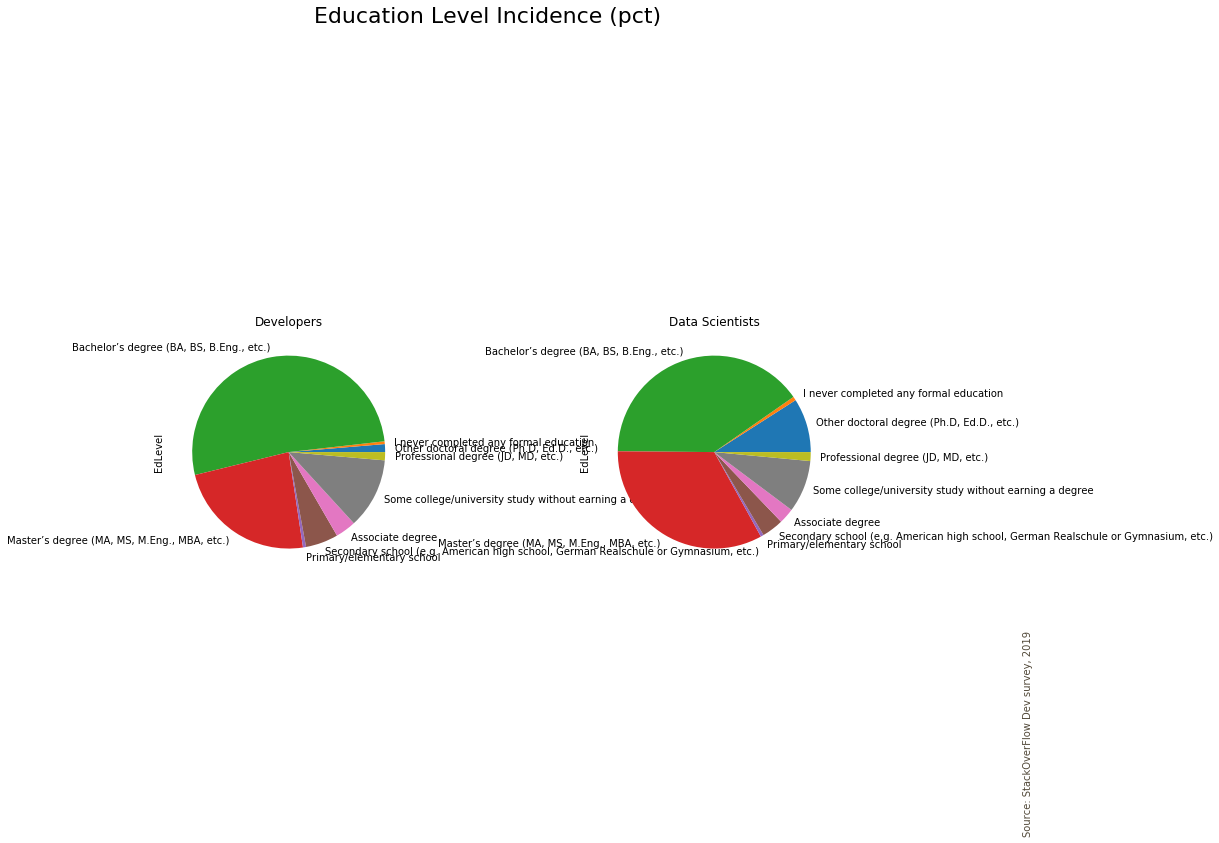

In [31]:
# plot EdLevel and Education summaries for DS and non-DS

title_text = 'Education Level Incidence (pct)'
xlimit = {0, 55}
xlabel_text = 'percent'
ylabel_text = 'educatation'
df_plot1 = 100*df.EdLevel[df['notDS']].value_counts('mean', sort=False)
df_plot2 = 100*df.EdLevel[df['isDS']].value_counts('mean', sort=False)
df_plot2 = df_plot2[df_plot1.index]
plot_2col(df_plot1, df_plot2, title_text, xlimit,
          xlabel_text, ylabel_text, 'pie')
# df_plot1.unstack(-1).plot.barh()
# df_plot1

The incidence of Data Scientist with advanced degrees is 17 percentage points higher than non Data Scientists.

College    -15.796559
Grade       -1.647514
Advanced    17.444073
Name: Education, dtype: float64

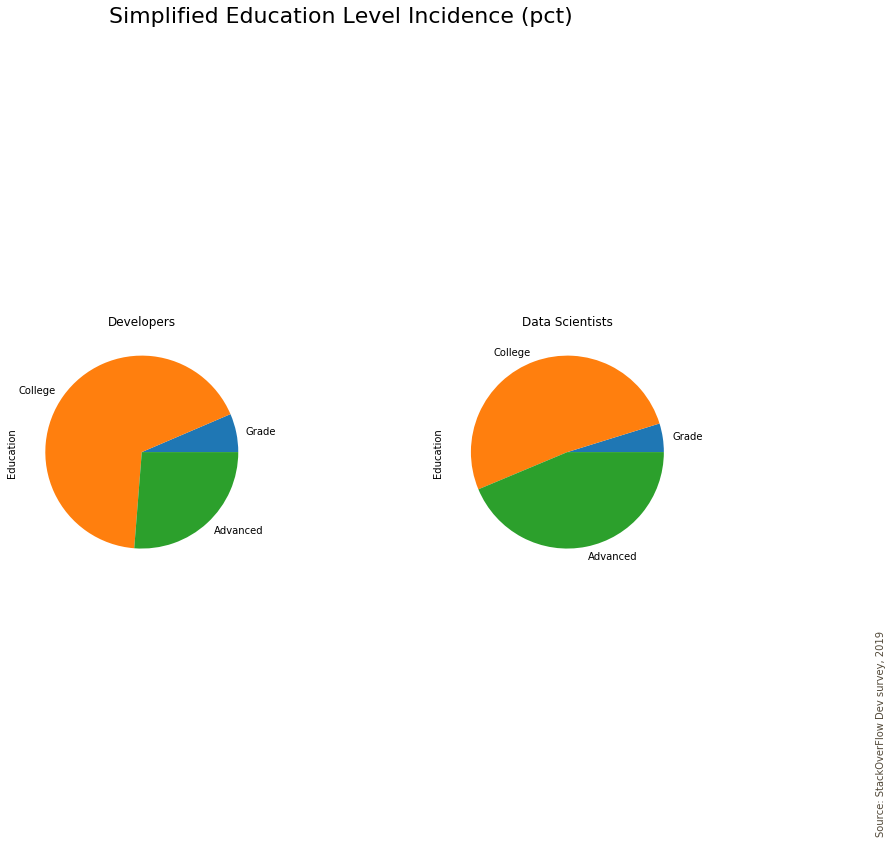

In [34]:
# plot EdLevel and Education summaries for DS and non-DS

title_text = 'Simplified Education Level Incidence (pct)'
xlimit = {0, 70}
xlabel_text = 'percent'
ylabel_text = 'educatation'
df_plot1 = 100*df.Education[df['notDS']].value_counts('mean', sort=False)
df_plot2 = 100*df.Education[df['isDS']].value_counts('mean', sort=False)
df_plot2 = df_plot2[df_plot1.index]
plot_2col(df_plot1, df_plot2, title_text, xlimit,
          xlabel_text, ylabel_text, 'pie')
# df_plot1.unstack(-1).plot.barh()
# df_plot1
(df_plot2-df_plot1).sort_values()

In [35]:
# plot UndergradMajor and Major summaries for DS and non-DS
df.loc[:, 'Major'] = np.nan

computer_tech = df['UndergradMajor'].isin(['Computer science, computer engineering, or software engineering',
                                           'Web development or web design',
                                           'Information systems, information technology, or system administration'])

math_sci = df['UndergradMajor'].isin(['Mathematics or statistics',
                                      'Another engineering discipline (ex. civil, electrical, mechanical)',
                                      'A natural science (ex. biology, chemistry, physics)'])

other = df['UndergradMajor'].isin(['A health science (ex. nursing, pharmacy, radiology)',
                                   'A business discipline (ex. accounting, finance, marketing)',
                                   'A humanities discipline (ex. literature, history, philosophy)',
                                   'A social science (ex. anthropology, psychology, political science)',
                                   'Fine arts or performing arts (ex. graphic design, music, studio art)'])


df.loc[computer_tech, 'Major'] = 'Computer/Tech'
df.loc[math_sci, 'Major'] = 'Math/Science'
df.loc[other, 'Major'] = 'Other'
#df.loc[no_answer,'EdLevel_simple'] = 'N/A'

df.loc[:, 'Major'] = df.Major.astype('category')
df['Major'].value_counts()
# survey.UndergradMajor.cat.categories

Computer/Tech    46509
Math/Science      8697
Other             4244
Name: Major, dtype: int64

Data Scientists with Math/Science degres are +12pp higher than non-Data Scientists, but the vast majority (almost 3/4) have computer / tech degrees.

Computer/Tech   -11.931466
Other            -0.443680
Math/Science     12.375146
Name: Major, dtype: float64

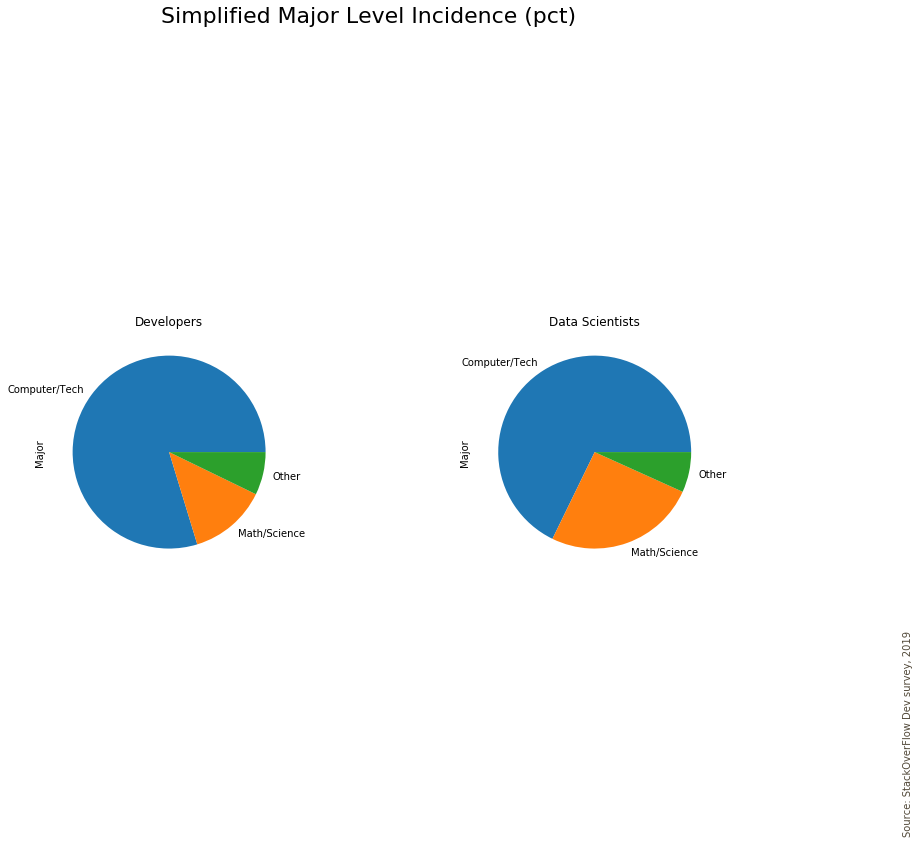

In [36]:
# plot Major summaries for DS and non-DS
title_text = 'Simplified Major Level Incidence (pct)'
xlimit = {0, 70}
xlabel_text = 'percent'
ylabel_text = 'educatation'
df_plot1 = 100*df.Major[df['notDS']].value_counts('mean', sort=False)
df_plot2 = 100*df.Major[df['isDS']].value_counts('mean', sort=False)
df_plot2 = df_plot2[df_plot1.index]
plot_2col(df_plot1, df_plot2, title_text, xlimit,
          xlabel_text, ylabel_text, 'pie')
(df_plot2-df_plot1).sort_values()


----
**Hypothesis:**  *DS started coding early*

### Demographic 2 - coding experience, age, Generation, and compensation

How long have they been coding?  When did they first start?  

In [41]:
def fix_years_coding(years_):
    # - years coding, years experience: `YearsCode` -> `nYearsCode`, change "Less than 1 year" to 1/10000 and "More than 50" to 55.
    # - years pro:`YearsCodePro` -> `nYearsPro`
    # make these numeric in a sensible way
    if years_ == 'Less than 1 year':
        return 0.0001
    elif years_ == 'More than 50 years':
        return 55.
    else:
        return years_


df.loc[:, 'nYearsCode'] = pd.to_numeric(df.YearsCode.apply(fix_years_coding))
df.loc[:, 'nYearsPro'] = pd.to_numeric(df.YearsCodePro.apply(fix_years_coding))

df.groupby('isDS').nYearsCode.agg(['count', 'mean', 'median', 'sem', 'max', 'min'])

,count,mean,median,sem,max,min
isDS,,,,,,
False,57205,12.505760,10.0,0.036295,55.0,0.0001
True,8028,14.205157,11.0,0.109687,55.0,0.0001


Data Scientists tend to have been coding for a long time, and have some people in the cohort who have been in professionals for a long time.  Althouth the median years professional is the same, there average years Pro is one year higher for Data Scientists at 9 years.

In [42]:
df.groupby('isDS').nYearsPro.agg(['count', 'mean', 'median', 'sem', 'max', 'min'])

,count,mean,median,sem,max,min
isDS,,,,,,
False,57100,7.934979,6.0,0.030514,55.0,0.0001
True,8009,9.152582,6.0,0.094180,55.0,0.0001


In [39]:
def fix_age1stcode(years_):
    # - Age: `Age`-> `nAge`  change < 13, or > 80 to `NaN`
    if years_ == 'Younger than 5 years':
        return 4.5
    elif years_ == 'Older than 85':
        return 85.
    else:
        return years_


df.loc[:, 'nAgeCode'] = pd.to_numeric(df.Age1stCode.apply(fix_age1stcode))

df.groupby('isDS').nAgeCode.agg(
    ['count', 'mean', 'median', 'sem', 'max', 'min'])


,count,mean,median,sem,max,min
isDS,,,,,,
False,57041,15.369033,15.0,0.019425,85.0,4.5
True,8002,14.901337,15.0,0.053720,85.0,4.5


So its not surprising that there might be more individuals who started coding at very young ages among Data Scientists. The mean is lower than the median, which is identical between Data Scientists and non-Data Scientis at 15 years young!

In [43]:
print('The dataset contains', df.shape[0], 'rows and', df.shape[1], 'columns.')

The dataset contains 65679 rows and 65 columns.


 ----
**Hypothesis:**  *DS follow some generational trends*
![alt text][logo]

[logo]:
https://www.pewresearch.org/wp-content/uploads/2019/01/FT_19.01.17_generations_2019.png


In [44]:
def fix_age(years_):
    # - 1st Code: `Age1stCode` -> `nAgeCode` , change "Younger than 5 years" to 4.5 and "Older than 85" to 85.
    # make these numeric in a sensible way  exclude pre-teens and aged >84
    if years_ < 13:
        return np.NaN
    elif years_ > 84:
        return np.NaN
    else:
        return years_


df.loc[:, 'nAge'] = pd.to_numeric(df.Age.apply(fix_age))

In [45]:
# Convert Age to generation with 2019 as current time reference
def find_gen(age):
    """
    """
    if age <= 22:
        gen = 'GenZ'
        return gen
    elif age <= 38:
        gen = 'Millenial'
    elif age <= 54:
        gen = 'GenX'
    elif age <= 73:
        gen = 'Boomer'
    else:
        gen = 'Silent'
    return gen


generation_cat = CategoricalDtype(['GenZ',
                                   'Millenial',
                                   'GenX',
                                   'Boomer',
                                   'Silent',  # 'N/A'
                                   ], ordered=True)

# Apply function to subsets
df.loc[:, 'Gen'] = np.nan
df.loc[:, 'Gen'] = df.Age.apply(find_gen).copy()
df.loc[:, 'Gen'] = df.Gen.astype(generation_cat)

Millenial   -3.666389
GenZ        -1.530008
Boomer       0.957908
Silent       1.442091
GenX         2.796397
Name: Gen, dtype: float64

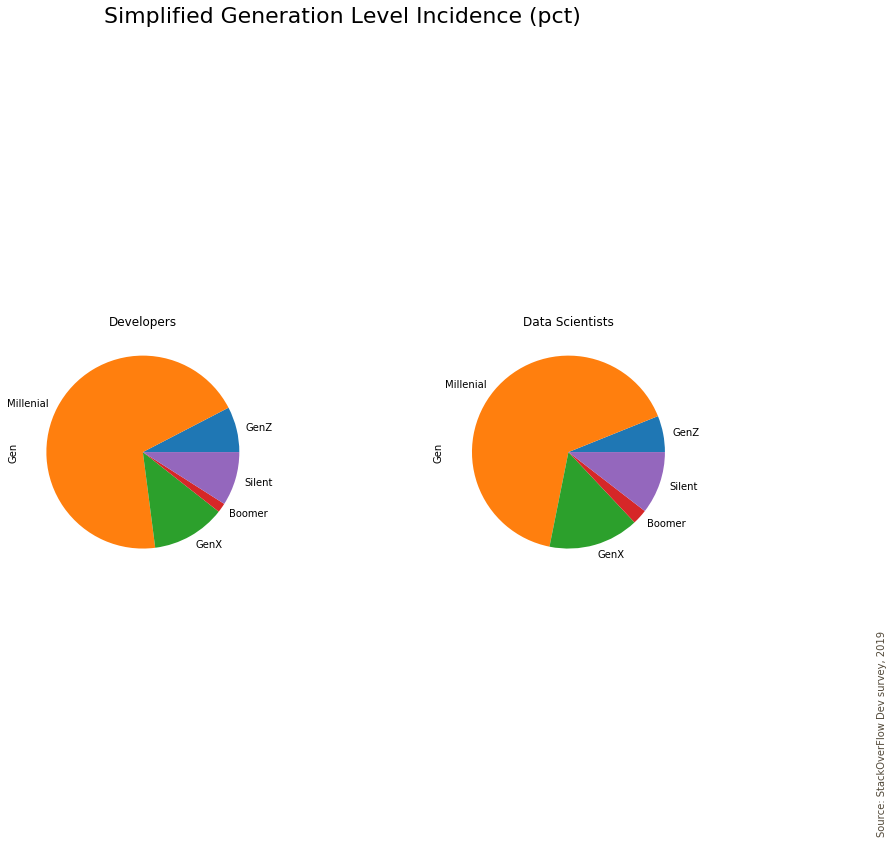

In [48]:
# plot Major summaries for DS and non-DS
title_text = 'Simplified Generation Level Incidence (pct)'
xlimit = {0, 70}
xlabel_text = 'percent'
ylabel_text = 'educatation'
df_plot1 = 100*df.Gen[df['notDS']].value_counts('mean', sort=False)
df_plot2 = 100*df.Gen[df['isDS']].value_counts('mean', sort=False)
df_plot2 = df_plot2[df_plot1.index]
plot_2col(df_plot1, df_plot2, title_text, xlimit,
          xlabel_text, ylabel_text, 'pie')
(df_plot2-df_plot1).sort_values()


Although most of the respondents are Millenials, it is very interesting that our Data Scientists tend to have an older component of GenX, Boomers, and even Silent generation members.


 ### Demographic 4 - Misc, sexuality, country of origin, gender, workweek, and compensation
    - [note: should recategorize the multi-selects as "other" ]
----
**Hypothesis:**  The data set will be heavily skewed to coders -- white dudes -- and very US-centric, but Data Scientists will draw in a slightly more balanced group.

### Demographic 4 -  Misc: sexuality, country of origin, gender, workweek, and compensation

How long have they been coding?  When did they first start?   

In [94]:
def fix_workweekhours(hours_):
    # - workweek: `WorkWeekHrs` to require 4 hours off per day
    # hard ceiling on hours in a week (24*7)  lets throw out the ridiculous no sleep 24/7 scenarios
    if hours_ > 20*7:
        return np.NaN
    elif hours_ < 4:  # arbitrary minimum work time
        return np.NaN
    else:
        return hours_


df.loc[:, 'WorkWeekH'] = df.WorkWeekHrs.copy().apply(fix_workweekhours)
df['WorkWeekH'].max()

140.0

In [95]:
# def new_sex(sex_):
#     #         ['Bisexual', 'Bisexual;Gay or Lesbian',
#     #                   'Bisexual;Gay or Lesbian;Straight / Heterosexual',
#     #                   'Bisexual;Straight / Heterosexual', 'Gay or Lesbian',
#     #                   'Gay or Lesbian;Straight / Heterosexual',
#     #                   'Straight / Heterosexual'],

#     if sex_=='Bisexual':
#         pass
#     if sex_=='Gay or Lesbian':
#         pass
#     if sex_=='Straight / Heterosexual':
#         pass
#     else:
#         return 'Other'

# s = df.Sexuality
# s2 = df.Sexuality.copy()

# s2.cat.set_categories(['Bisexual',
#        'Gay or Lesbian',
#        'Straight / Heterosexual' ])

# df.loc[:, 'Sexuality2'] = s2
# df['Sexuality'].dtypes
# df['Sexuality2'].describe()

# s = df.Sexuality
# s2 = df.Sexuality.copy()

# s2.cat.set_categories(['Bisexual',
#        'Gay or Lesbian',
#        'Straight / Heterosexual'])

# s2.cat.remove_categories([ 'Bisexual;Gay or Lesbian',
#        'Bisexual;Gay or Lesbian;Straight / Heterosexual',
#        'Bisexual;Straight / Heterosexual',
#        'Gay or Lesbian;Straight / Heterosexual'])
# s2.cat.categories

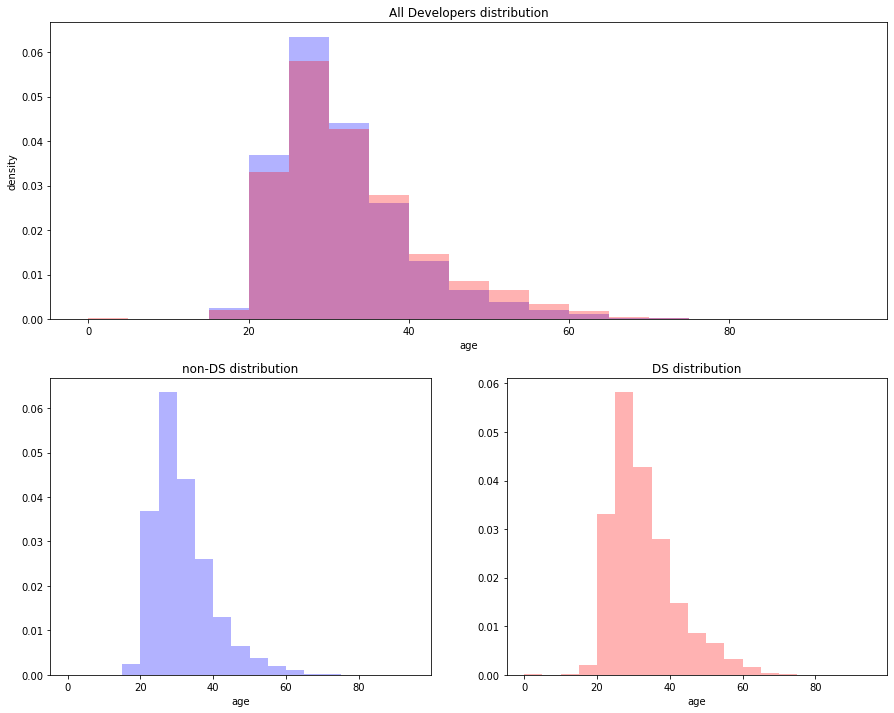

In [96]:
fig = plt.figure(figsize=(15, 12))
ylimit = {0, .07}
xlabel_text = 'age'
ylabel_text = 'density'
df_plot1 = df.Age[df['notDS']]
df_plot2 = df.Age[df['isDS']]

# Plot them as a histogram.
title_text = 'All Developers distribution'
plt.subplot(2, 1, 1)
plt.hist(df_plot1, density=True, color='blue',
         bins=np.arange(0, 100, 5), alpha=.3)
# Plot them as a histogram.
plt.hist(df_plot2, density=True, color='red',
         bins=np.arange(0, 100, 5), alpha=.3)
plt.title(title_text)
plt.xlabel(xlabel_text)
plt.ylabel(ylabel_text)

title_text = 'non-DS distribution'
plt.subplot(2, 2, 3)
plt.hist(df_plot1, density=True, color='blue',
         bins=np.arange(0, 100, 5), alpha=.3)
plt.title(title_text)
plt.xlabel(xlabel_text)

title_text = 'DS distribution'
plt.subplot(2, 2, 4)
plt.hist(df_plot2, density=True, color='red',
         bins=np.arange(0, 100, 5), alpha=.3)
plt.title(title_text)
plt.xlabel(xlabel_text)


plt.show()

There's clearly more older respondents in the DS group.  This can be seen as the points abouve the unity line in Q-Q plot for non-DS vs DS.

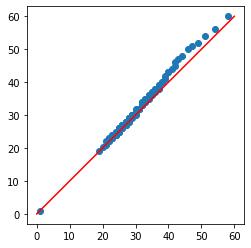

In [97]:
# percentile list
perc = [.10, .25, .50, .75, .90]

plt.scatter(x=df_plot1.quantile(np.linspace(0, 1, 100, 0)),
            y=df_plot2.quantile(np.linspace(0, 1, 100, 0)))
plt.plot([0, 60], [0, 60], color='r')
plt.gca().set_aspect('equal', adjustable='box')
fig.tight_layout()

In [98]:
# CREATE A FIGURE WITH HISTOGRAMS OF SALARY for each generation

In [99]:
df.groupby('Gen').ConvertedComp.agg(
    ['count', 'mean', 'median', 'sem', 'max', 'min'])

,count,mean,median,sem,max,min
Gen,,,,,,
GenZ,3574,67505.028819,19236.0,3701.555070,2000000.0,0.0
Millenial,37425,121506.230969,53850.0,1448.691504,2000000.0,0.0
GenX,6654,176570.177638,93492.0,3793.224584,2000000.0,0.0
Boomer,796,209459.015075,110000.0,13164.119463,2000000.0,0.0
Silent,2053,138289.154408,60000.0,6762.615024,2000000.0,0.0


Data Scientists actually look to be slightly older than non-DS developers. And their experience and tenure help them generate higher salaries.

In [58]:
# Looks like the middle 50% of people mostly work 40 hours weeks, but some extreme outliers exist...
pd.concat([df.WorkWeekH[df['notDS']].dropna().describe(percentiles=perc).rename('Hours_NotDS'),
           (df.WorkWeekH[df['isDS']].dropna().describe(percentiles=perc)).rename('Hours_DS')],
          axis=1)

,Hours_NotDS,Hours_DS
count,50671.000000,7050.000000
mean,40.148769,41.384865
std,9.725670,11.390711
min,4.000000,4.000000
10%,35.000000,30.000000
25%,40.000000,40.000000
50%,40.000000,40.000000
75%,42.000000,45.000000
90%,50.000000,50.000000
max,140.000000,120.000000


In [59]:
compStats = df.dropna().groupby('Country').ConvertedComp.agg(
    ['count', 'mean', 'median']).sort_values('median', ascending=False)
compStats = compStats[compStats['count'] > 4]
compStats.head(10)

# looks like the US has lots of "outliers" but is still the highes paid

,count,mean,median
Country,,,
United States,2380,248564.467227,110000.0
Switzerland,101,153918.851485,96646.0
Israel,51,95456.000000,95664.0
Denmark,57,113883.473684,87468.0
Norway,67,186391.835821,82946.0
Australia,228,191039.061404,79057.5
Ireland,54,215333.629630,73328.0
Iceland,5,71750.400000,70152.0
Canada,335,136660.026866,68705.0


Strangely, ther rare women in our dataset seem to be slighlty better paid. 1.02 cents on the doller median wage.  However, some the mean pay is slightly higer for men. For DataScientists the median wage is slightly smaller (94.46 cents on the dollar), but the average is higher!!  On _AVERAGE_ women are paid 19% more.

In [60]:
df.dropna().groupby('Gender').ConvertedComp.agg(
    ['count', 'mean', 'median']).sort_values('median', ascending=False)

,count,mean,median
Gender,,,
"Non-binary, genderqueer, or gender non-conforming",21,234388.857143,78207.0
"Man;Non-binary, genderqueer, or gender non-conforming",12,79897.416667,68665.0
Woman,296,134814.422297,65154.0
Man,7203,139614.393308,64115.0
"Woman;Non-binary, genderqueer, or gender non-conforming",9,55470.666667,32064.0
Woman;Man,3,12224.000000,6276.0
"Woman;Man;Non-binary, genderqueer, or gender non-conforming",0,NaN,NaN


In [61]:
df[df['notDS']].dropna().groupby('Gender').ConvertedComp.agg(
    ['count', 'mean', 'median']).sort_values('median', ascending=False)

,count,mean,median
Gender,,,
"Non-binary, genderqueer, or gender non-conforming",15,256132.200000,70000.0
"Man;Non-binary, genderqueer, or gender non-conforming",9,70502.777778,65330.0
Woman,265,130247.328302,65308.0
Man,6304,138765.574397,64152.0
"Woman;Non-binary, genderqueer, or gender non-conforming",8,58396.500000,40452.0
Woman;Man,2,16764.000000,16764.0
"Woman;Man;Non-binary, genderqueer, or gender non-conforming",0,NaN,NaN


In [62]:
df[df['isDS']].dropna().groupby('Gender').ConvertedComp.agg(
    ['count', 'mean', 'median']).sort_values('median', ascending=False)

,count,mean,median
Gender,,,
"Man;Non-binary, genderqueer, or gender non-conforming",3,108081.333333,140000.0
"Non-binary, genderqueer, or gender non-conforming",6,180030.500000,116500.0
Man,899,145566.511680,63514.0
Woman,31,173855.709677,60000.0
"Woman;Non-binary, genderqueer, or gender non-conforming",1,32064.000000,32064.0
Woman;Man,1,3144.000000,3144.0
"Woman;Man;Non-binary, genderqueer, or gender non-conforming",0,NaN,NaN


In [63]:
df_plot1 = df[df['Gender'] == 'Man'].ConvertedComp
df_plot2 = df[df['Gender'] == 'Woman'].ConvertedComp
qs = np.linspace(0, 1, 100, 0)
qx = df_plot1.quantile(qs)
qy = df_plot2.quantile(qs)

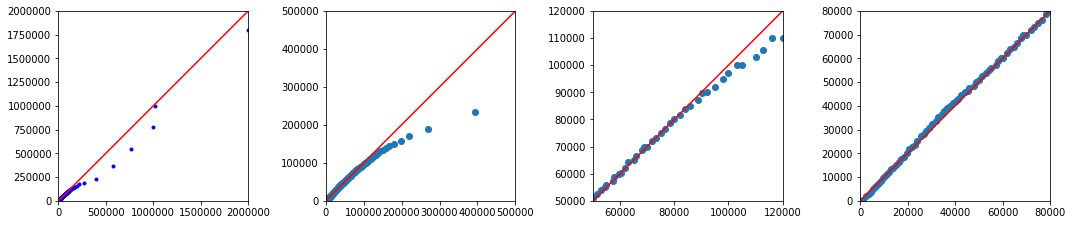

In [64]:
fig = plt.figure(figsize=(15, 12))
ylimit = {0, .07}
xlabel_text = 'compensation'
ylabel_text = 'density'
# df_plot1 = df.ConvertedComp[df['Gender']=='Man']
# df_plot2 = df.ConvertedComp[df['Gender']=='Woman']

df_plot1 = df[df['Gender'] == 'Man'].ConvertedComp
df_plot2 = df[df['Gender'] == 'Woman'].ConvertedComp
qs = np.linspace(0, 1, 100, 0)
qx = df_plot1.quantile(qs)
qy = df_plot2.quantile(qs)


plt.subplot(1, 4, 1)
plt.plot(qx, qy, 'b.')
rangex = [0, qx.max()]
plt.plot(rangex, rangex, color='r')
plt.gca().set(xlim={rangex[0], rangex[1]}, ylim={rangex[0], rangex[1]})
plt.gca().set_aspect('equal', adjustable='box')

rangex = [0, 500000]
plt.subplot(1, 4, 2)
plt.scatter(x=df_plot1.quantile(np.linspace(0, 1, 100, 0)),
            y=df_plot2.quantile(np.linspace(0, 1, 100, 0)))
plt.plot(rangex, rangex, color='r')
plt.gca().set(xlim={rangex[0], rangex[1]}, ylim={rangex[0], rangex[1]})
plt.gca().set_aspect('equal', adjustable='box')
fig.tight_layout()

rangex = [50000, 120000]
xhi = 100000.
plt.subplot(1, 4, 3)
plt.scatter(x=df_plot1.quantile(np.linspace(0, 1, 100, 0)),
            y=df_plot2.quantile(np.linspace(0, 1, 100, 0)))
plt.plot(rangex, rangex, color='r')
plt.gca().set(xlim={rangex[0], rangex[1]}, ylim={rangex[0], rangex[1]})
plt.gca().set_aspect('equal', adjustable='box')
fig.tight_layout()

rangex = [0, 80000]
plt.subplot(1, 4, 4)
plt.scatter(x=df_plot1.quantile(np.linspace(0, 1, 100, 0)),
            y=df_plot2.quantile(np.linspace(0, 1, 100, 0)))
plt.plot(rangex, rangex, color='r')
plt.gca().set(xlim={rangex[0], rangex[1]}, ylim={rangex[0], rangex[1]})
plt.gca().set_aspect('equal', adjustable='box')
fig.tight_layout()

Text(0, 0.5, 'density')

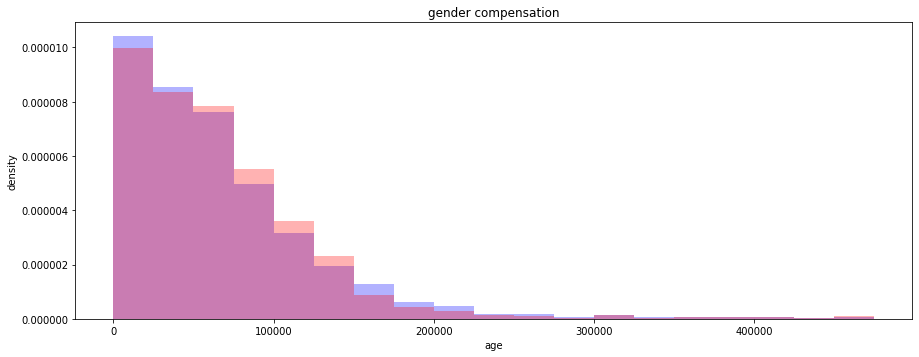

In [65]:
fig = plt.figure(figsize=(15, 12))
ylimit = {0, .07}
xlabel_text = 'age'
ylabel_text = 'density'
# df_plot1 = df.ConvertedComp[df['Gender']=='Man']
# df_plot2 = df.ConvertedComp[df['Gender']=='Woman']

df_plot1 = df[df['Gender'] == 'Man'].ConvertedComp
df_plot2 = df[df['Gender'] == 'Woman'].ConvertedComp
qs = np.linspace(0, 1, 100, 0)
qx = df_plot1.quantile(qs)
qy = df_plot2.quantile(qs)

# Plot them as a histogram.
title_text = 'gender compensation'
plt.subplot(2, 1, 1)
histM = plt.hist(df_plot1, density=True, color='blue',
                 bins=np.arange(0, 500000, 25000), alpha=.3)
# Plot them as a histogram.
histF = plt.hist(df_plot2, density=True, color='red',
                 bins=np.arange(0, 500000, 25000), alpha=.3)
plt.title(title_text)
plt.xlabel(xlabel_text)
plt.ylabel(ylabel_text)

# title_text = 'non-DS distribution'
# plt.subplot(2,2,3)
# plt.hist(df_plot1, density=True, color='blue', bins=np.arange(0, 500000, 25000), alpha=.3)
# plt.title(title_text)
# plt.xlabel(xlabel_text)

# title_text = 'DS distribution'
# plt.subplot(2,2,4)
# plt.hist(df_plot2, density=True, color='red', bins=np.arange(0, 500000, 25000), alpha=.3)
# plt.title(title_text)
# plt.xlabel(xlabel_text)


# title_text = 'ds/nonDS'
# plt.subplot(2,1,2)
# plt.hist(histF/histM, density=True, color='blue', bins=np.arange(0, 500000, 25000), alpha=.3)
# plt.title(title_text)
# plt.xlabel(xlabel_text)


# (df['a']
#  .pipe(lambda s: pd.Series(np.histogram(s, range=(0, 100), bins=20)))
#  .pipe(lambda s: pd.Series(s[0], index=s[1][:-1]))
# )
# You can then pipe on more things at the end, like:

# .pipe(lambda s: s/s.sum())

In [66]:
# seems like the incidence seems pretty gen-pop representative.. maybe higher bi than gay..
# might want to loook deeper at respondents who chose BOTH straight and Gay / Bi

100*df['Sexuality'].value_counts() / df.shape[0]

Straight / Heterosexual                            80.993925
Bisexual                                            3.553647
Gay or Lesbian                                      1.959530
Bisexual;Straight / Heterosexual                    0.516147
Bisexual;Gay or Lesbian                             0.115714
Bisexual;Gay or Lesbian;Straight / Heterosexual     0.089831
Gay or Lesbian;Straight / Heterosexual              0.036541
Name: Sexuality, dtype: float64

In [73]:
# almost 1% trans...
df['Trans'].value_counts()

No     61714
Yes      598
Name: Trans, dtype: int64

In [74]:
# Looks like the middle 50% of people mostly work 40 hours weeks, but some extreme outliers exist...
df.Sexuality[df['Trans'] == 'Yes'].value_counts()

Bisexual                                           181
Gay or Lesbian                                     111
Straight / Heterosexual                             75
Bisexual;Gay or Lesbian;Straight / Heterosexual     20
Bisexual;Gay or Lesbian                             19
Gay or Lesbian;Straight / Heterosexual               6
Bisexual;Straight / Heterosexual                     6
Name: Sexuality, dtype: int64

In [70]:
100*df.Sexuality[df['Trans'] == 'Yes'].value_counts() / \
    df.Sexuality.value_counts()

Bisexual                                            7.754927
Bisexual;Gay or Lesbian                            25.000000
Bisexual;Gay or Lesbian;Straight / Heterosexual    33.898305
Bisexual;Straight / Heterosexual                    1.769912
Gay or Lesbian                                      8.624709
Gay or Lesbian;Straight / Heterosexual             25.000000
Straight / Heterosexual                             0.140988
Name: Sexuality, dtype: float64

In [75]:
# Looks like some of the multi-select sexuality identification are also "trans"
pd.concat([df.Sexuality[df['Trans'] == 'Yes'].value_counts().rename('Trans'),
           df.Sexuality[df['Trans'] == 'No'].value_counts().rename('notTrans'),
           (100*df.Sexuality[df['Trans'] == 'Yes'].value_counts()/df.Sexuality.value_counts()).rename('pctTrans')],
          axis=1).sort_values('notTrans', ascending=False)

,Trans,notTrans,pctTrans
Straight / Heterosexual,75,52388,0.140988
Bisexual,181,2060,7.754927
Gay or Lesbian,111,1154,8.624709
Bisexual;Straight / Heterosexual,6,324,1.769912
Bisexual;Gay or Lesbian,19,54,25.000000
Bisexual;Gay or Lesbian;Straight / Heterosexual,20,26,33.898305
Gay or Lesbian;Straight / Heterosexual,6,17,25.000000


In [76]:
# Looks like some of the multi-select sexuality identification are also "trans"
pd.concat([(100*df['Country'].value_counts()/df.shape[0]).rename('all'),
           (100*df.loc[data_scientist, 'Country'].value_counts()/data_scientist.sum()).rename('DS')],
          axis=1, sort=True).sort_values('DS', ascending=False).head(30)

,all,DS
United States,24.513163,27.119275
India,10.135660,8.911506
Germany,6.461731,6.578131
United Kingdom,6.784513,5.647263
Canada,3.812482,3.711059
Brazil,2.303628,2.594018
France,2.678177,2.432667
Australia,2.181824,2.345786
Netherlands,2.073722,2.184436
Poland,2.260997,1.911381


----
## QUESTION #2:  Are Data Scientist's attitudes different?  

**Hypothesis:** More likely to be susceptible to the Dunning-Kruger Effect of overestimating you.  (But lets face it, the entier cohort of developers shows this in spades).

                 

,ImpSyn_NotDS,ImpSyn_DS,difference (~DS-DS)
Far below average,1.975046,2.332873,-0.357827
A little below average,7.224139,5.719303,1.504837
Average,24.291656,19.402985,4.888671
A little above average,45.896823,42.430704,3.466120
Far above average,20.612335,30.114135,-9.501800


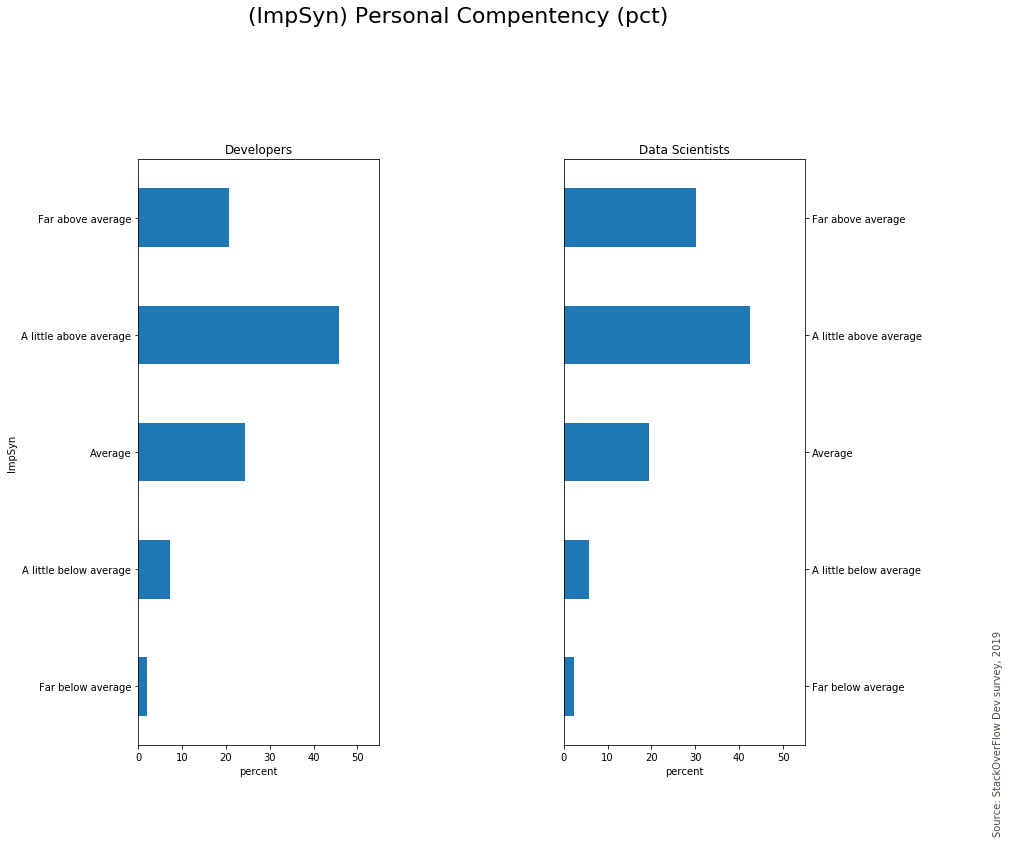

In [102]:
# plot ImpSyn ..
title_text = '(ImpSyn) Personal Compentency (pct)'
xlimit = {0, 55}
xlabel_text = 'percent'
ylabel_text = 'ImpSyn'
df_plot1 = 100*df.ImpSyn[df['notDS']].value_counts('mean', sort=False)
df_plot2 = 100*df.ImpSyn[df['isDS']].value_counts('mean', sort=False)
#df_plot2 = df_plot2[df_plot1.index]
plot_2col(df_plot1, df_plot2, title_text, xlimit,
          xlabel_text, ylabel_text, 'barh')
# df_plot1.unstack(-1).plot.barh()
# df_plot1
pd.concat([df_plot1.rename('ImpSyn_NotDS'),
           df_plot2.rename('ImpSyn_DS'),
           (df_plot1-df_plot2).rename('difference (~DS-DS)')],
          axis=1)

Only 20% of data scientists consider themselves to be of "average" ability...

In [103]:
attitude_cols = ['ImpSyn', 'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney', 'MgrWant', 'JobFactors',
                 'BlockchainIs', 'BetterLife', 'ITperson', 'OffOn',  'SocialMedia', 'Extraversion',
                 'ScreenName', 'OpenSource']

In [104]:
# extraversion . better life
title_text = '(Extraversion) ---'
xlimit = {0, 80}
xlabel_text = 'percent'
ylabel_text = 'Extraversion'
df_plot1 = 100*df.Extraversion[df['notDS']].value_counts('mean', sort=False)
df_plot2 = 100*df.Extraversion[df['isDS']].value_counts('mean', sort=False)
#df_plot2 = df_plot2[df_plot1.index]
#plot_2col(df_plot1, df_plot2, title_text, xlimit, xlabel_text, ylabel_text,'barh')
# df_plot1.unstack(-1).plot.barh()
# df_plot1

pd.concat([df_plot1.rename('Extraversion_NotDS'),
           df_plot2.rename('Extraversion_DS'),
           (df_plot1-df_plot2).rename('difference (~DS-DS)')],
          axis=1)

,Extraversion_NotDS,Extraversion_DS,difference (~DS-DS)
In real life (in person),60.971048,63.022993,-2.051944
Neither,10.666714,10.566654,0.100060
Online,28.362238,26.410353,1.951885


In [105]:
# plot
title_text = '(MgrWant ---'
xlimit = {0, 55}
xlabel_text = 'percent'
ylabel_text = 'MgrWant'
df_plot1 = 100*df.MgrWant[df['notDS']].value_counts('mean', sort=False)
df_plot2 = 100*df.MgrWant[df['isDS']].value_counts('mean', sort=False)
# df_plot2 = df_plot2[df_plot1.index]
# plot_2col(df_plot1, df_plot2, title_text, xlimit, xlabel_text, ylabel_text,'barh')
# df_plot1.unstack(-1).plot.barh()
# df_plot1

pd.concat([df_plot1.rename('MgrWant_NotDS'),
           df_plot2.rename('MgrWant_DS'),
          (df_plot1-df_plot2).rename('difference (~DS-DS)'],
                 axis=1)

SyntaxError: invalid syntax (<ipython-input-105-b0017bd9646f>, line 15)

In [106]:
# plot blockchain versus salary or years experience..?
# 'BlockchainIs',

title_text = '(BlockchainIs) ---'
xlimit = {0, 55}
xlabel_text = 'percent'
ylabel_text = 'BlockchainIs'
df_plot1 = 100*df.BlockchainIs[df['notDS']].value_counts('mean', sort=True)
df_plot2 = 100*df.BlockchainIs[df['isDS']].value_counts('mean', sort=True)
#df_plot2 = df_plot2[df_plot1.index]
#plot_2col(df_plot1, df_plot2, title_text, xlimit, xlabel_text, ylabel_text,'barh')
# df_plot1.unstack(-1).plot.barh()
# df_plot1

pd.concat([df_plot1.rename('BlockchainIs_NotDS'),
           df_plot2.rename('BlockchainIs_DS'),
           (df_plot1-df_plot2).rename('difference (~DS-DS)')],
          axis=1)

,BlockchainIs_NotDS,BlockchainIs_DS,difference (~DS-DS)
A passing fad,17.727226,15.296880,2.430346
An irresponsible use of resources,16.180966,15.850386,0.330580
Useful across many domains and could change many aspects of our lives,27.830141,30.526669,-2.696528
"Useful for decentralized currency (i.e., Bitcoin)",10.813634,10.130829,0.682805
Useful for immutable record keeping outside of currency,27.448033,28.195236,-0.747203


In [107]:
#'BlockchainIs', 'BetterLife',   'ITperson', 'SocialMedia',  'ScreenName',  'OpenSource'

title_text = '(BetterLife) ---'
xlimit = {0, 55}
xlabel_text = 'percent'
ylabel_text = 'BetterLife'
df_plot1 = 100*df.BetterLife[df['notDS']].value_counts('mean', sort=False)
df_plot2 = 100*df.BetterLife[df['isDS']].value_counts('mean', sort=False)
#df_plot2 = df_plot2[df_plot1.index]
#plot_2col(df_plot1, df_plot2, title_text, xlimit, xlabel_text, ylabel_text,'barh')
# df_plot1.unstack(-1).plot.barh()
# df_plot1

pd.concat([df_plot1.rename('BetterLife_NotDS'),
           df_plot2.rename('BetterLife_DS'),
           (df_plot1-df_plot2).rename('difference (~DS-DS)')],
          axis=1)

,BetterLife_NotDS,BetterLife_DS,difference (~DS-DS)
No,37.268221,36.86085,0.407372
Yes,62.731779,63.13915,-0.407372


,SocialMedia_NotDS,SocialMedia_DS,difference (~DS-DS)
Hello,0.012700,0.013029,-0.000329
Youku Tudou 优酷,0.021771,0.013029,0.008742
Weibo 新浪微博,0.059872,0.052117,0.007754
Snapchat,0.502558,0.599349,-0.096790
VK ВКонта́кте,0.691244,0.599349,0.091896
WeChat 微信,0.776516,0.521173,0.255343
LinkedIn,5.172539,7.843648,-2.671109
I don't use social media,6.248412,8.000000,-1.751588
Instagram,7.581915,6.384365,1.197550
Twitter,14.614101,13.667752,0.946348


/Users/ergonyc/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20248 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ergonyc/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 37239 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ergonyc/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ergonyc/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 28010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ergonyc/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 24494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ergonyc/anaconda3/lib/python3.7/site-packages/matplotlib/backends/ba

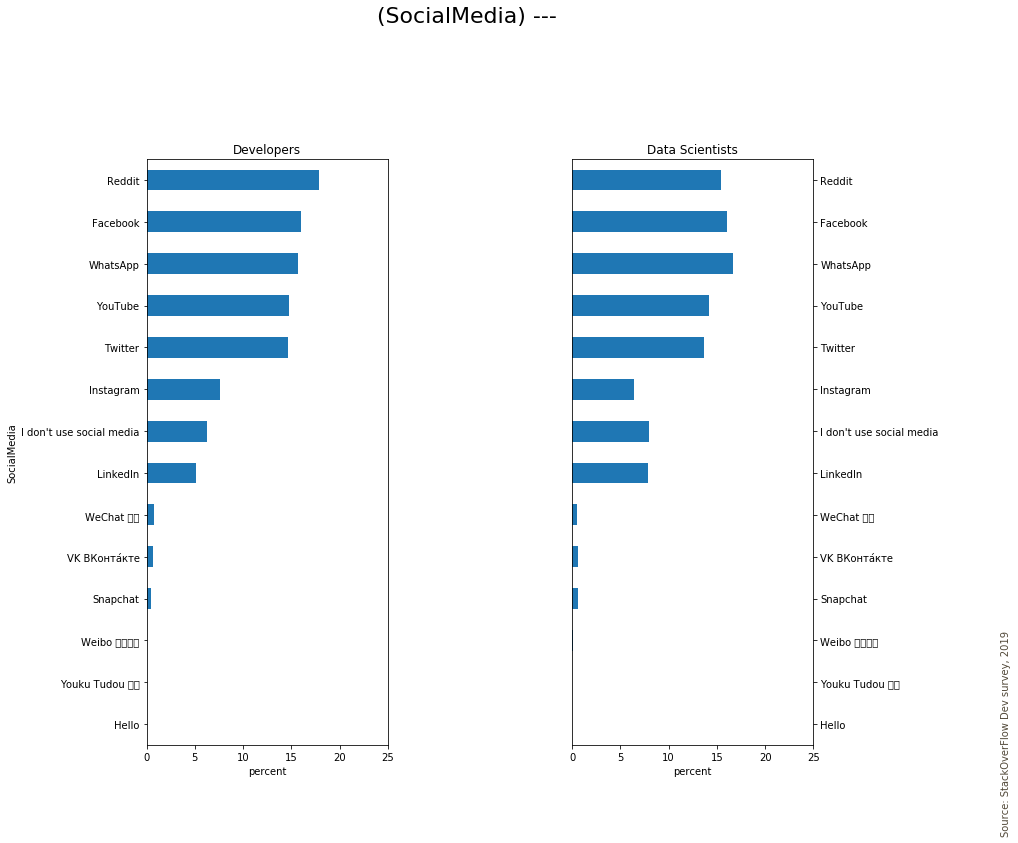

In [108]:
#'ITperson', 'SocialMedia',  'ScreenName',  'OpenSource'
# more likely to be on LinkedIN . correlats with "MANAGER?"

title_text = '(SocialMedia) ---'
xlimit = {0, 25}
xlabel_text = 'percent'
ylabel_text = 'SocialMedia'
df_plot1 = 100*df.SocialMedia[df['notDS']
                              ].value_counts('mean').sort_values(ascending=True)
df_plot2 = 100*df.SocialMedia[df['isDS']].value_counts('mean')
df_plot2 = df_plot2[df_plot1.index]
plot_2col(df_plot1, df_plot2, title_text, xlimit,
          xlabel_text, ylabel_text, 'barh')
# df_plot1.unstack(-1).plot.barh()
# df_plot1

pd.concat([df_plot1.rename('SocialMedia_NotDS'),
           df_plot2.rename('SocialMedia_DS'),
           (df_plot1-df_plot2).rename('difference (~DS-DS)')],
          axis=1)

In [109]:
# ''ScreenName',  'OpenSource'

title_text = '(ScreenName) ---'
xlimit = {0, 55}
xlabel_text = 'percent'
ylabel_text = 'ScreenName'
df_plot1 = 100*df.ScreenName[df['notDS']].value_counts('mean', sort=False)
df_plot2 = 100*df.ScreenName[df['isDS']].value_counts('mean', sort=False)
#df_plot2 = df_plot2[df_plot1.index]
#plot_2col(df_plot1, df_plot2, title_text, xlimit, xlabel_text, ylabel_text,'barh')
# df_plot1.unstack(-1).plot.barh()
# df_plot1

pd.concat([df_plot1.rename('ScreenName_NotDS'),
           df_plot2.rename('ScreenName_DS'),
           (df_plot1-df_plot2).rename('difference (~DS-DS)')],
          axis=1)

,ScreenName_NotDS,ScreenName_DS,difference (~DS-DS)
Handle,4.977341,5.121918,-0.144577
Login,10.834381,11.156518,-0.322138
Screen Name,2.422027,2.506471,-0.084444
UserID,7.665943,10.025882,-2.359939
Username,74.100308,71.189211,2.911097


In [110]:
# ''ScreenName',  'OpenSource'

title_text = '(OpenSource) ---'
xlimit = {0, 55}
xlabel_text = 'percent'
ylabel_text = 'OpenSource'
df_plot1 = 100*df.OpenSource[df['notDS']].value_counts('mean', sort=False)
df_plot2 = 100*df.OpenSource[df['isDS']].value_counts('mean', sort=False)
#df_plot2 = df_plot2[df_plot1.index]
#plot_2col(df_plot1, df_plot2, title_text, xlimit, xlabel_text, ylabel_text,'barh')
# df_plot1.unstack(-1).plot.barh()
# df_plot1

pd.concat([df_plot1.rename('OpenSource_NotDS'),
           df_plot2.rename('OpenSource_DS'),
           (df_plot1-df_plot2).rename('difference (~DS-DS)')],
          axis=1)

,OpenSource_NotDS,OpenSource_DS,difference (~DS-DS)
"OSS is, on average, of HIGHER quality than proprietary / closed source software",42.048489,43.780657,-1.732168
The quality of OSS and closed source software is about the same,48.517215,45.918752,2.598463
"OSS is, on average, of LOWER quality than proprietary / closed source software",9.434296,10.300591,-0.866295


RESULTS:       
1.0.1.
3. How much coding experience do data scientists have compared to non-data scientists?
HISTOGRAMS
> - years experience
> - age first code

barh

5. Life shit.  attitudes
> - impsyn
> manager competence (?)

----
## QUESTION #3:  Are Data Scientist's skills & work situations different?  

**Hypothesis:** More likely to be ...


RESULTS:       
1.0.1.

1. How does the demographic profile of data scientists differ from that of non-data scientists?
> - male/female ratio
> - incident of out "other"/trans

> - dependents
> - US vs other
>

RESULTS:       
1.0.1.

2. What programming languages do data scientists favour and how do they differ from those used by non-data scientists?
> - histograms

RESULTS:       
1.0.1.
4. Are data scientists more satisfied with their jobs/careers than non-data scientists?
> - salary
> - feelings of managers

In [ ]:
work_cols = ['ConvertedComp',  'WorkWeekHrs' 'Employment', 'OrgSize']  # ,
             # 'JobSeek', 'LastHireDate', 'LastInt', 'ResumeUpdate',
             # 'CompTotal', 'CurrencySymbol','CurrencyDesc', 'CompTotal', 'CompFreq',
             # 'WorkPlan', 'WorkChallenge', 'WorkRemote', 'WorkLoc', 'CodeRev', 'CodeRevHrs', 'UnitTests',
             # 'PurchaseHow', 'PurchaseWhat']

# keep all of these
skills_cols = ['YearsCode', 'Age1stCode', 'YearsCodePro', 'OpenSourcer', 'DevType',  'LanguageWorkedWith',
               'LanguageDesireNextYear', 'DevEnviron', 'OpSys', 'Containers', 'BlockchainOrg', 'FizzBuzz',
               'DatabaseWorkedWith', 'DatabaseDesireNextYear', 'PlatformWorkedWith',   'PlatformDesireNextYear',

----
## QUESTION #3:  Can we predict if a developer professional developer is a Data Scientist?

**Hypothesis:** Encoded in the responses is a graph which tells us if a coder is a data scientist. 

Hopefully the signature will be strong enough to be predictive in valuable and useful situations.




### Column Cleanup
- Drop columns which we don't want to anlayze
- re-order/group columns (in case we want to select with slices?)
- Remove all leading and trailing spaces (not nescessary)
- Rename the columns for consistency (not nescessary)

In [111]:
new_columns = ['Education', 'Major', 'nYearsCode', 'nAgeCode', 'nAge'
               'nYearsPro', 'WorkWeekH', 'Gen',
               'isDS', 'notDS', 'isDev', 'DSonly', 'DSandDev', 'otherDev']

In [112]:
# SKIP ALL STACKOVERFLOW PARTICULARS
#'JobSeek','LastHireDate', 'LastInt',
#'WorkPlan', 'WorkChallenge',
#' WorkRemote', 'WorkLoc',
#'CodeRev', 'CodeRevHrs', 'UnitTests',
#'PurchaseHow', 'PurchaseWhat',
# Skip these
# 'WebFrameWorkedWith','WebFrameDesireNextYear',
# Print shape of dataset
print(
    f'The dataset now contains {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset now contains 65679 rows and 68 columns.


In [113]:
isDS = df['isDS']
isDev = df['notDS']

---
## Split Multi-Selection Fields 

For the fields where multiple selections were possible (e.g.  `JobFactors`,`DevEnviron`, and `LanguageWorkedWith`), split the strings containing the multiple selections into a list of selections and then concatenate these lists into a single list (dropping any missing values in the process). 

We may also want to simplify these fields to reduce the length of category labels and to group similar categories into a single category apon further analysis.
This splitting will be the basis for Language, DB, Tech "FEELINGS" analysis as well.


In [114]:
# We have to split the LanguageWorkedWith to get a proper picture
#languages = survey[survey['LanguageWorkedWith'].notnull()]


def split_multiselect(df, col):
    """Create a new dataframe that splits the values of multi-selection column col into individual selections and 
    places each selection into a boolean column. This new dataframe can be merged into the original dataframe by 
    Respondent (index)value.

    Args:
    df: dataframe. Dataframe containing the multi-selection field col.
    col:  column name

    Returns:
    out_df: dataframe. New dataframe giving split values of col.
        """

    unique_selects = {}

    select_na = df[col].isnull()
    # split the languages on ;
    # for language_set in survey['LanguageWorkedWith'].dropna().apply(lambda row: str(row).split(';')) :
    for select_set in df[col].apply(lambda row: str(row).split(';')):
        for select in select_set:
            if select not in unique_selects.keys():
                unique_selects[select] = 1
            else:
                unique_selects[select] += 1

    un_sel = pd.Series(unique_selects).sort_values(ascending=False).copy()
    #un_sel.index == 'nan'
    out_df = pd.DataFrame()  # columns = unique_selects)
    new_cols = []
    for sel in un_sel.index:
        col_name = col[:25] + '_' + sel.replace(' ', '_')
        new_cols.append(col_name)
        if (sel == 'nan'):
            out_df.loc[:, col_name] = select_na
        else:
            out_df.loc[:, col_name] = ~ select_na  # df[col]
            selected = df[col].dropna().str.split(';').copy()  # .tolist()
            # need to strip the nulls
            out_df.loc[~select_na, col_name] = selected.apply(
                lambda x: sel in x)
            out_df.loc[select_na, col_name] = np.nan

    return out_df, new_cols

### JobFactor & WorkChallenges 

`JobFactors`,`WorkChallenge`


In [115]:
jobfact, jobfact_cols = split_multiselect(df, 'JobFactors')
jobchal, jobchal_cols = split_multiselect(df, 'WorkChallenge')

KeyError: 'WorkChallenge'

In [ ]:
jobf_dev = (100*jobfact[isDev].mean()).sort_values(ascending=False)
sorted_index = jobf_dev.index
jobf_ds = (100*jobfact[isDS].mean())
jobf_ds = jobf_ds[sorted_index]
jobf_ = pd.DataFrame(jobf_dev - jobf_ds)

In [ ]:
jobf_['dev'] = (jobf_dev)
jobf_['DS'] = (jobf_ds)
jobf_

In [ ]:
title_text = 'Job Factors'
xlimit = {0, 75}
ylabel_text = 'Language'
pd.DataFrame(jobf_dev - jobf_ds).plot.barh()

In [ ]:
plot_dev_vs_df(jobf_dev, jobf_ds, title_text, xlimit, ylabel_text)

### Development Environment 

`DevEnviron`

In [116]:
devenv, devenv_cols = split_multiselect(df, 'DevEnviron')

In [117]:
# how many environs do each respondent claim :  almost 3!!!
devenv.sum(axis=1).describe()

count    65679.000000
mean         2.826946
std          1.599255
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         22.000000
dtype: float64

### Containers

`Containers`

In [118]:
containers, containers_cols = split_multiselect(df, 'Containers')

## and convert Now+Future into _FEELINGS_

- Love - use and want to continue next year
- Hate - use and want to stop next year
- Desire - don't use but want to next year


For the fields where multiple selections were possible (e.g.  `JobFactors`,`DevEnviron`, and `LanguageWorkedWith`), split the strings containing the multiple selections into a list of selections and then concatenate these lists into a single list (dropping any missing values in the process). 

We may also want to simplify these fields to reduce the length of category labels and to group similar categories into a single category apon further analysis.

Full list of the multi-select variables we will be addressing:
 `JobFactors`,`DevEnviron`,`Containers`,`WorkChallenge`, as well as the current/future pairs:
     `LanguageWorkedWith`, `LanguageDesireNextYear`, 
     `DatabaseWorkedWith`,`DatabaseDesireNextYear`, 
     `MiscTechWorkedWith`,`MiscTechDesireNextYear`, 
     `PlatformWorkedWith`, `PlatformDesireNextYear`,


In [119]:
def split_multiselect_love_hate(df, col, col_next, prefix):
    """Create a new dataframe that splits the values of multi-selection column col into individual selections and
    places each selection into a boolean column. This new dataframe can be merged into the original dataframe by
    Respondent (index)value.

    Args:
    df: dataframe. Dataframe containing the multi-selection field col.
    col:  column name
    col_next:  column name for "next year" multi-select
    prefix: how to name the new columns e.g. 'Lang' (&'LangNext') for 'LanguageWorkedWith'&'LanguageDesiredNextYear'

    Returns:
    out_df: dataframe. New dataframe giving split values of col.
        """

    unique_selects = {}
    # split the languages on ;
    # for language_set in survey['LanguageWorkedWith'].dropna().apply(lambda row: str(row).split(';')) :
    for select_set in df[col].apply(lambda row: str(row).split(';')):
        for select in select_set:
            if select not in unique_selects.keys():
                unique_selects[select] = 1
            else:
                unique_selects[select] += 1

    #     unique_selects_next = {}
    #     # split the languages on ;
    #     # for language_set in survey['LanguageWorkedWith'].dropna().apply(lambda row: str(row).split(';')) :
    #     for select_set in df[col_next].apply(lambda row: str(row).split(';')):
    #         for select in select_set:
    #             if select not in unique_selects_next.keys():
    #                 unique_selects_next[select] = 1
    #             else:
    #                 unique_selects_next[select] += 1

    # unique_selects.keys() == unique_selects_next.keys()
    un_sel = pd.Series(unique_selects).sort_values(ascending=False).copy()
    #un_sel_next = pd.Series(unique_selects_next).sort_values(ascending=False).copy()

    # out_df = pd.DataFrame()  # columns = unique_selects)
    out_df = df.loc[:, [col, col_next]]  # columns = unique_selects)

    select_na = df[col].isnull()
    select_na_next = df[col_next].isnull()

    new_cols = []
    # new_cols_next = []

    for sel in un_sel.index:
        # first lets
        # col_name = col[:25] + '_' + sel.replace(' ', '_')
        col_name = prefix + '_' + sel.replace(' ', '_')
        col_name_next = prefix + 'Next_' + sel.replace(' ', '_')
        col_name_love = prefix + 'Love_' + sel.replace(' ', '_')
        col_name_hate = prefix + 'Hate_' + sel.replace(' ', '_')
        col_name_desire = prefix + 'Desire_' + sel.replace(' ', '_')

        new_cols.append(col_name)
        new_cols.append(col_name_next)
        new_cols.append(col_name_love)
        new_cols.append(col_name_hate)
        new_cols.append(col_name_desire)

        if (sel == 'nan'):
            # this is a holding tally for how many non-selctions we have...
            # so should be true for respondents who have nans in other entries
            new_col = select_na
            new_col_next = select_na_next
            # these are pretty non-sensicle for nan
            # this is defensive... not nescessary?
            love = (~select_na)
            # this is defensive... not nescessary?
            hate = (~select_na)
            # any non-nan entries are "desired" but dangerous
            desire = (~select_na_next)

        else:
            new_col = ~select_na  # this is defensive... not nescessary?
            love = ~select_na  # this is defensive... not nescessary?
            hate = ~select_na  # this is defensive... not nescessary?

            selected = df[col].dropna().str.split(';').copy()
            # need to strip the nulls
            new_col[~select_na] = selected.apply(lambda x: sel in x)

            new_col_next = ~select_na_next  # this is defensive... not nescessary?
            desire = ~select_na_next
            selected_next = df[col_next].dropna().str.split(';').copy()
            # need to strip the nulls
            new_col_next[~select_na_next] = selected_next.apply(
                lambda x: sel in x)

            love = ((new_col == True) & (new_col_next == True))
            hate = ((new_col == True) & (new_col_next == False))
            desire = ((new_col == False) & (new_col_next == True))

            # can only "love/hate" it if you alread do it..
            love[(new_col == False)] = np.nan
            hate[(new_col == False)] = np.nan
            # can only "desire" it if you don't alread do it..
            desire[(new_col == True)] = np.nan

            # put the nonentries back in place
            new_col[select_na] = np.nan
            new_col_next[select_na_next] = np.nan

            love[select_na] = np.nan
            love[select_na_next] = np.nan
            hate[select_na] = np.nan
            desire[select_na_next] = np.nan

        out_df.loc[:, col_name] = new_col.astype('float64')
        out_df.loc[:, col_name_next] = new_col_next.astype('float64')

        out_df.loc[:, col_name_love] = love.astype('float64')
        out_df.loc[:, col_name_hate] = hate.astype('float64')
        out_df.loc[:, col_name_desire] = desire.astype('float64')

    return out_df, new_cols

### Languages 

`LanguageWorkedWith`, `LanguageDesireNextYear`, 


In [120]:
col = 'LanguageWorkedWith'
col_next = 'LanguageDesireNextYear'
prefix = 'Lang'
langs_df, Lang_cols = split_multiselect_love_hate(df, col, col_next, prefix)

In [121]:
langs_df.iloc[:, 0:15].head(35)

,LanguageWorkedWith,LanguageDesireNextYear,Lang_JavaScript,LangNext_JavaScript,LangLove_JavaScript,LangHate_JavaScript,LangDesire_JavaScript,Lang_HTML/CSS,LangNext_HTML/CSS,LangLove_HTML/CSS,LangHate_HTML/CSS,LangDesire_HTML/CSS,Lang_SQL,LangNext_SQL,LangLove_SQL
Respondent,,,,,,,,,,,,,,,
4,C;C++;C#;Python;SQL,C;C#;JavaScript;SQL,0.0,1.0,NaN,NaN,1.0,0.0,0.0,NaN,NaN,0.0,1.0,1.0,1.0
5,C++;HTML/CSS;Java;JavaScript;Python;SQL;VBA,HTML/CSS;Java;JavaScript;SQL;WebAssembly,1.0,1.0,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,1.0,1.0,1.0
7,HTML/CSS;JavaScript,HTML/CSS;JavaScript,1.0,1.0,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,0.0,0.0,NaN
9,Bash/Shell/PowerShell;C#;HTML/CSS;JavaScript;P...,Bash/Shell/PowerShell;C;HTML/CSS;JavaScript;Ru...,1.0,1.0,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,1.0,1.0,1.0
10,C#;Go;JavaScript;Python;R;SQL,C#;Go;JavaScript;Kotlin;Python;R;SQL,1.0,1.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,1.0,1.0,1.0
13,Bash/Shell/PowerShell;HTML/CSS;JavaScript;PHP;...,Bash/Shell/PowerShell;HTML/CSS;JavaScript;Rust...,1.0,1.0,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,1.0,1.0,1.0
14,C++,C++,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN
16,Bash/Shell/PowerShell;C#;HTML/CSS;JavaScript;T...,C#;HTML/CSS;JavaScript;TypeScript;WebAssembly;...,1.0,1.0,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,0.0,0.0,NaN
17,Bash/Shell/PowerShell;HTML/CSS;JavaScript;Type...,Bash/Shell/PowerShell;HTML/CSS;Java;JavaScript...,1.0,1.0,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,0.0,0.0,NaN


In [122]:
# We have to split the LanguageWorkedWith to get a proper picture
#languages = survey[survey['LanguageWorkedWith'].notnull()]

col = 'LanguageWorkedWith'
col_next = 'LanguageDesireNextYear'
prefix = 'Lang'

unique_selects = {}
# split the languages on ;
# for language_set in survey['LanguageWorkedWith'].dropna().apply(lambda row: str(row).split(';')) :
for select_set in df[col].apply(lambda row: str(row).split(';')):
    for select in select_set:
        if select not in unique_selects.keys():
            unique_selects[select] = 1
        else:
            unique_selects[select] += 1


unique_selects_next = {}
# split the languages on ;
# for language_set in survey['LanguageWorkedWith'].dropna().apply(lambda row: str(row).split(';')) :
for select_set in df[col_next].apply(lambda row: str(row).split(';')):
    for select in select_set:
        if select not in unique_selects_next.keys():
            unique_selects_next[select] = 1
        else:
            unique_selects_next[select] += 1

#unique_selects.keys() == unique_selects_next.keys()
un_sel = pd.Series(unique_selects).sort_values(ascending=False).copy()
un_sel_next = pd.Series(unique_selects_next).sort_values(
    ascending=False).copy()

Incidence of language mentions for now and last year indicate that Javascript is the top dawg but losing steam (though the TypeScript and WebAssembly flavors are up and coming), and traditional HTML/CSS also seems to be on the decline.   Go and Python seem to be steadily growing in interest, with Go, Kotlin, Clojure, Rust and Dart seeming to have emerging interest.  

In [123]:
# #pd.DataFrame([un_sel,un_sel_next])  # columns = unique_selects)
langs = pd.concat([un_sel, un_sel_next], axis=1, sort=False)
# langs.sum(axis=1)
langs.columns = [col, col_next]
langs['NowVsNextYear'] = (langs[col_next]-langs[col])
langs['pctInterestNext'] = (100*(langs[col_next]-langs[col])/langs[col])

In [124]:
# raw difference in mentions
langs.sort_values('NowVsNextYear', ascending=True)

,LanguageWorkedWith,LanguageDesireNextYear,NowVsNextYear,pctInterestNext
HTML/CSS,41911,27420,-14491,-34.575648
JavaScript,46945,34194,-12751,-27.161572
SQL,37235,25290,-11945,-32.080032
Java,26348,16583,-9765,-37.061637
Bash/Shell/PowerShell,24195,15428,-8767,-36.234759
PHP,17042,8636,-8406,-49.325197
C,11130,6694,-4436,-39.856244
C#,21657,17300,-4357,-20.118207
C++,13296,10434,-2862,-21.525271
VBA,2987,762,-2225,-74.489454


In [125]:
# This is how to merge the "splits" back into the main DF (for regressions...)
#df_ = df.merge(langs, how='outer', left_index=True, right_index=True)
# df_.shape

Now we need to look at what percentage of each language users LOVE, or HATE that language.  And what the raw percentage of non-users are interested in the language.

Lets plot as some horizontal bar graphs next to the raw incidence of language use for all Professionals and then with Developers and DataScientists broken out.



In [126]:
title_text = 'Incidence of Language used'
xlimit = {0, 75}
ylabel_text = 'Language'

plot_dev_vs_df(lang_dev, lang_ds, title_text, xlimit, ylabel_text)

NameError: name 'lang_dev' is not defined

In [ ]:
# DataFrame.hist(data, column=None, by=None, grid=True,
#  xlabelsize=None, xrot=None, ylabelsize=None,
#  yrot=None, ax=None, sharex=False, sharey=False,
#  figsize=None, layout=None, bins=10,

In [ ]:
langs = langs_df.filter(regex='Lang_')
#langs = langs.merge(df['DSorDV'], how='outer', left_index=True, right_index=True)
# langs.groupby('DSorDV').mean()

In [ ]:
lang_dev = (100*langs[isDev].mean()).sort_values(ascending=True)
sorted_index = lang_dev.index
lang_ds = (100*langs[isDS].mean())
lang_ds = lang_ds[sorted_index]
lang_pct = (100*langs[isDev].mean()).sort_values(ascending=True)
lang_pct = lang_pct[sorted_index]

In [ ]:
filt = langs_df.filter(regex='LangLove_')
love = filt.drop(columns='LangLove_nan')

love_dev = (100*love[isDev].mean()).sort_values(ascending=True)
love_ds = (100*love[isDS].mean()).sort_values(ascending=True)
#love_ds = love_ds[love_dev.index]
title_text = 'language LOVE (of current users, percent who WANT to use next year)'

xlimit = {0, 95}
ylabel_text = 'Language'

plot_dev_vs_df(love_dev, love_ds, title_text, xlimit, ylabel_text)

In [ ]:
filt = langs_df.filter(regex='LangHate')
hate = filt.drop(columns='LangHate_nan')


hate_dev = (100*hate[isDev].mean()).sort_values(ascending=True)
hate_ds = (100*hate[isDS].mean()).sort_values(ascending=True)

title_text = 'language HATE (of current users, percent who DO NOT want to use it next year)'

xlimit = {0, 85}
ylabel_text = 'Language'

plot_dev_vs_df(hate_dev, hate_ds, title_text, xlimit, ylabel_text)

In [ ]:
filt = langs_df.filter(regex='LangDesire')
desire = filt.drop(columns='LangDesire_nan')

des_dev = (100*desire[isDev].mean()).sort_values(ascending=True)
des_ds = (100*desire[isDS].mean()).sort_values(ascending=True)

title_text = 'language DESIRE (of non-users, percent who WANT to use it next year)'

xlimit = {0, 35}
ylabel_text = 'Language'

plot_dev_vs_df(des_dev, des_ds, title_text, xlimit, ylabel_text)

In [ ]:
col = 'PlatformWorkedWith'
col_next = 'PlatformDesireNextYear'
prefix = 'Platform'
platform_df, Platform_cols = split_multiselect_love_hate(
    df, col, col_next, prefix)

In [ ]:
plats = platform_df.filter(regex='Platform_')
plats = plats.drop(columns='Platform_nan')

plats_dev = (100*plats[isDev].mean()).sort_values(ascending=True)
plats_ds = (100*plats[isDS].mean()).sort_values(ascending=True)

title_text = 'incidence of platforms used'
xlimit = {0, 75}
ylabel_text = 'Platform'
plot_dev_vs_df(plats_dev, plats_ds, title_text, xlimit, ylabel_text)

In [ ]:
# plats = platform_df.filter(regex='PlatformDesire_')
# plats = plats.drop(columns='PlatformDesire_nan')

# platsd_dev = (100*plats[isDev].mean()).sort_values(ascending=True)
# platsd_ds = (100*plats[isDS].mean()).sort_values(ascending=True)

# platsd_dev.plot.barh(figsize=(10, 10))

# platsd_ds.plot.barh(figsize=(10, 10))

In [ ]:
col = 'DatabaseWorkedWith'
col_next = 'DatabaseDesireNextYear'
prefix = 'DB'
db_df, DB_cols = split_multiselect_love_hate(df, col, col_next, prefix)

In [ ]:
dbs = db_df.filter(regex='DB_')
dbs = dbs.drop(columns='DB_nan')

dbs_dev = (100*dbs[isDev].mean()).sort_values(ascending=True)
dbs_ds = (100*dbs[isDS].mean()).sort_values(ascending=True)

title_text = 'incidence of database used'
xlimit = {0, 60}
ylabel_text = 'Database'
plot_dev_vs_df(dbs_dev, dbs_ds, title_text, xlimit, ylabel_text)

In [ ]:
col = 'MiscTechWorkedWith'
col_next = 'MiscTechDesireNextYear'
prefix = 'Tech'
tech_df, Tech_cols = split_multiselect_love_hate(df, col, col_next, prefix)

In [ ]:
techs = tech_df.filter(regex='Tech_')
techs = techs.drop(columns='Tech_nan')

techs_dev = (100*techs[isDev].mean()).sort_values(ascending=True)
techs_ds = (100*techs[isDS].mean()).sort_values(ascending=True)

title_text = 'incidence of technology used'
xlimit = {0, 60}
ylabel_text = 'Tech'
plot_dev_vs_df(dbs_dev, dbs_ds, title_text, xlimit, ylabel_text)

---

dont 

---

go 

---

below

---

here

---

throw out everything except a simple df

In [ ]:
import sklearn
from sklearn import svm, preprocessing

# always shuffle your data to avoid any biases that may emerge b/c of some order.
df = sklearn.utils.shuffle(df)

X = df.drop("price", axis=1).values
X = preprocessing.scale(X)
y = df["price"].values

test_size = 200

X_train = X[:-test_size]
y_train = y[:-test_size]

X_test = X[-test_size:]
y_test = y[-test_size:]

clf = svm.SVR(kernel='linear')
#clf = svm.SVR(kernel = 'rbf')

clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

for X, y in list(zip(X_test, y_test))[:10]:
    print(f"model predicts {clf.predict([X])[0]}, real value: {y}")

In [ ]:
#import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

sns.set_color_codes("pastel")
p = sns.countplot(data=techs)

#sns.barplot(x="MainBranch", y="abbrev", data=df, label="Count", color="b")


# Plot the crashes where alcohol was involved
# sns.set_color_codes("muted")
# sns.barplot(x="alcohol", y="abbrev", data=crashes,
#            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
#ax.legend(ncol=2, loc="lower right", frameon=True)
# ax.set(xlim=(0, 24), ylabel="",
#       xlabel="Automobile collisions per billion miles")
#sns.despine(left=True, bottom=True)

In [ ]:
# Generate 1000 random values.
x = np.random.normal(10, 5, 1000)
y = np.random.normal(11, 10, 1000)
# Plot them as a histogram.
plt.hist(x)
plt.show()  # Same data, this time normed, using density.
plt.hist(x, density=True, color='blue', bins=np.arange(-10, 40), alpha=.5)
plt.hist(y, density=True, color='red', bins=np.arange(-10, 40), alpha=.5)
plt.title('Normed histograms')
plt.xlabel('Random Values')

plt.show()


(data, column=None, by=None, grid=True,
#  xlabelsize=None, xrot=None, ylabelsize=None,
#  yrot=None, ax=None, sharex=False, sharey=False,
#  figsize=None, layout=None, bins=10,


print(set(df['region'].values.tolist()))

region_df=df.copy()[df['region'] == region]


graph_df=pd.DataFrame()

for region in df['region'].unique():
    region_df=df.copy()[df['region'] == region]
    region_df.set_index('Date', inplace=True)
    region_df.sort_index(inplace=True)
    region_df[f"{region}_price25ma"]=region_df["AveragePrice"].rolling(
        25).mean()

    if graph_df.empty:
        # note the double square brackets! (so df rather than series)
        graph_df=region_df[[f"{region}_price25ma"]]
    else:
        graph_df=graph_df.join(region_df[f"{region}_price25ma"])

graph_df.tail()

In [ ]:
# create figure and axis
fig, ax = plt.subplots()
# plot histogram


ax.hist(desireDS, bins=30, alpha=0.3, density=True,
        range={0, 1000000.}, color='r')
# set title and labels
ax.set_title('df')
ax.set_xlabel('muney')
ax.set_ylabel('Frequency')
ax.hist(desireDev, bins=30, alpha=0.3, density=True,
        range={0, 1000000.}, color='b')


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

sns.set_color_codes("pastel")
p = sns.countplot(data=df, x='MainBranch')

p = sns.countplot(data=df,
                  y='Category',
                  hue='DSorDV')


# Plot the total crashes
# sns.barplot(x="MainBranch", y="abbrev", data=df, label="Count", color="b")

# Plot the crashes where alcohol was involved
# sns.set_color_codes("muted")
# sns.barplot(x="alcohol", y="abbrev", data=crashes,
#            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
# ax.legend(ncol=2, loc="lower right", frameon=True)
# ax.set(xlim=(0, 24), ylabel="",
#       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

# Databases, Platforms, and Misc Tech

      `DatabaseWorkedWith`, `DatabaseDesireNextYear`,
     `MiscTechWorkedWith`,`MiscTechDesireNextYear`, 
     `PlatformWorkedWith`, `PlatformDesireNextYear`,

In [ ]:
df.pivot_table(['Total day calls', 'Total eve calls', 'Total night calls'],
               ['Area code'], aggfunc='mean')

pd.crosstab(df['Churn'], df['Voice mail plan'], normalize=True)


# Plotting a bar graph of the number of stores in each city, for the first ten cities listed
# in the column 'City'
city_count = df['City'].value_counts()
city_count = city_count[:10, ]
plt.figure(figsize=(10, 5))
sns.barplot(city_count.index, city_count.values, alpha=0.8)
plt.title('Starbucks in top 10 cities in the World')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('city', fontsize=12)
plt.show()

# DEPRICATED CODE 

Moved these munging/wrangling items to the bottom for sake of sharing

### zero order sanity checks
First lets see what features are in here, and see how complete it is... empty (`NaN`) entries...  complete columns... and columns with lots of missing data. 

In [ ]:
# what pct of of empty entries..
(100 * df.isna().sum() / df.shape[0]).describe()

In [ ]:
# check columns with no missing values
set(df.isna().sum()[df.isna().sum() == 0].keys())

In [ ]:
# check which columns have over 50% missing values
sum(df.columns[100*df.isna().sum()/df.shape[0] > 50])